## Testing trained model

In [1]:
import os, sys

project_root = os.path.abspath("../CellViT-plus-plus")  # from notebooks → project root
project_root = os.path.abspath("../Fusion/CellViT-plus-plus-rosie")  # from notebooks → project root
sys.path.append(project_root)

print(project_root)


/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Fusion/CellViT-plus-plus-rosie


## Fusion Model

In [3]:
# Baseline

CHECKPOINT = "ROSIE_TCGA_2/logs/2025-11-30T163450_baseline_rgb_128/checkpoints/model_best.pth"

import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from cellvit.models.cell_segmentation.cellvit_sam import RosieFusionCellViTSAM
from cellvit.training.datasets.rosie_tcga_dataset import RosieTCGADataset


# ---------------------------
# CONFIG
# ---------------------------
DATASET_PATH = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Fusion/CellViT-plus-plus-rosie/ProcessedData_npy"
CHECKPOINT_PATH = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ROSIE_TCGA_2/logs/2025-11-30T164656_baseline_rgb_128/checkpoints/model_best.pth"

DEVICE = "cuda:1"
N_SAMPLES = 3    # how many examples to visualize


# ---------------------------
# Load Dataset
# ---------------------------
dataset = RosieTCGADataset(DATASET_PATH, transforms=None)
print("Dataset size:", len(dataset))


# ---------------------------
# Load Model
# ---------------------------
model = RosieFusionCellViTSAM(
    model_path=None,
    num_nuclei_classes=6,
    num_tissue_classes=1,
    vit_structure="sam-h",
    in_chans=3,                 # baseline RGB only
    use_lora=False
)

print(f"Loading checkpoint: {CHECKPOINT_PATH}")
state = torch.load(CHECKPOINT_PATH, map_location="cpu")
model.load_state_dict(state, strict=False)
model.to(DEVICE)
model.eval()


# ---------------------------
# Helper for plotting
# ---------------------------
def show_tensor(t):
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    return t


def plot_example(img53, masks, pred, idx):
    fig, ax = plt.subplots(2, 5, figsize=(18, 7))
    fig.suptitle(f"Sample {idx}", fontsize=18)

    # --- INPUTS ---
    rgb = img53[:3].permute(1,2,0).cpu().numpy()

    ax[0,0].imshow(rgb)
    ax[0,0].set_title("Image")
    ax[0,0].axis("off")

    ax[0,1].imshow(masks["nuclei_binary_map"], cmap="jet")
    ax[0,1].set_title("Binary GT")
    ax[0,1].axis("off")

    ax[0,2].imshow(masks["hv_map"][0], cmap="jet")
    ax[0,2].set_title("HV-0 GT")
    ax[0,2].axis("off")

    ax[0,3].imshow(masks["hv_map"][1], cmap="jet")
    ax[0,3].set_title("HV-1 GT")
    ax[0,3].axis("off")

    ax[0,4].imshow(masks["nuclei_type_map"], cmap="tab10")
    ax[0,4].set_title("GT Type Map")
    ax[0,4].axis("off")


    # --- PREDICTIONS ---
    ax[1,1].imshow(show_tensor(pred["nuclei_binary_map"][0]), cmap="jet")
    ax[1,1].set_title("Pred Binary")
    ax[1,1].axis("off")

    hv_pred = pred["hv_map"]
    ax[1,2].imshow(show_tensor(hv_pred[0]), cmap="jet")
    ax[1,2].set_title("Pred HV-0")
    ax[1,2].axis("off")

    ax[1,3].imshow(show_tensor(hv_pred[1]), cmap="jet")
    ax[1,3].set_title("Pred HV-1")
    ax[1,3].axis("off")

    ax[1,4].imshow(show_tensor(pred["nuclei_type_map"][0]), cmap="tab10")
    ax[1,4].set_title("Pred Type Map")
    ax[1,4].axis("off")

    plt.tight_layout()
    plt.show()


# ---------------------------
# Run Example Predictions
# ---------------------------
for i in range(N_SAMPLES):
    img53, masks, _, _ = dataset[i]
    rgb = img53[:3].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(rgb, retrieve_tokens=False)

    plot_example(img53, masks, out, idx=i)


Dataset size: 2031


🔧 Configuring Trainable Parameters (Adapter + LoRA + Heads)...
Loading checkpoint: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ROSIE_TCGA_2/logs/2025-11-30T164656_baseline_rgb_128/checkpoints/model_best.pth


RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [32] and input of shape [1, 0, 256, 256]

Dataset size: 2031


Loading checkpoint: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ROSIE_TCGA_2/logs/2025-11-30T164656_baseline_rgb_128/checkpoints/model_best.pth


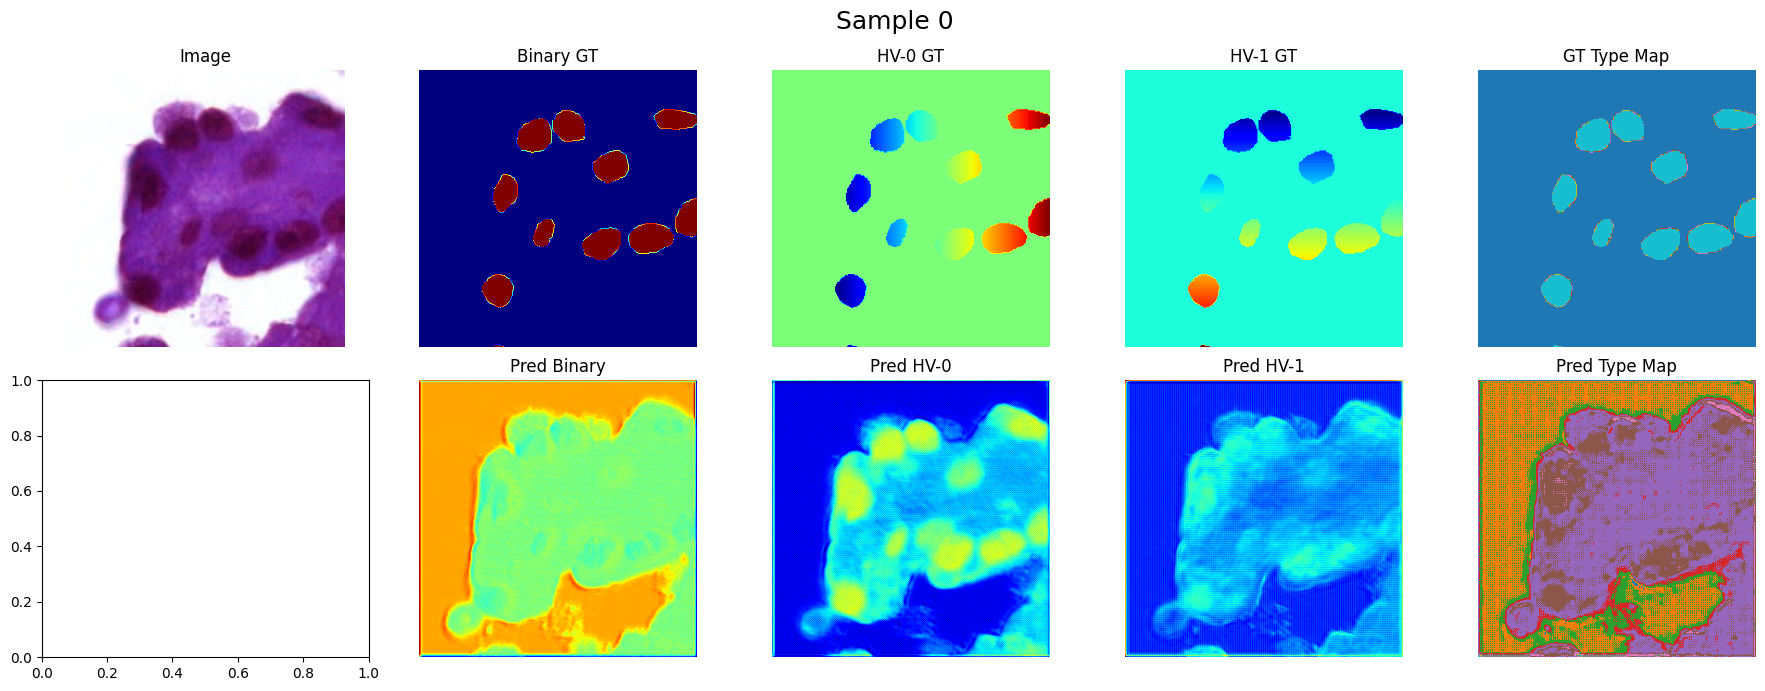

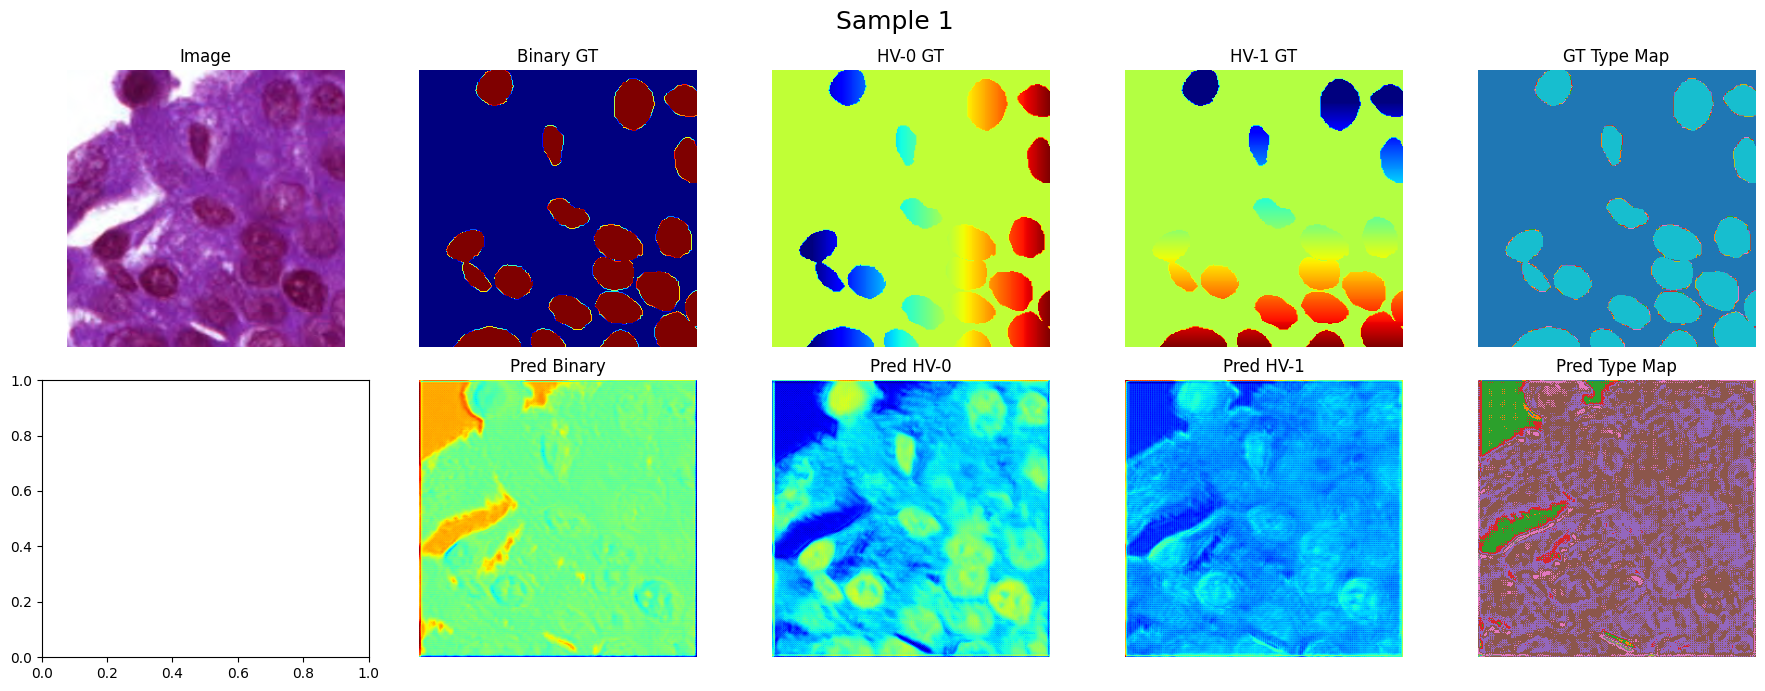

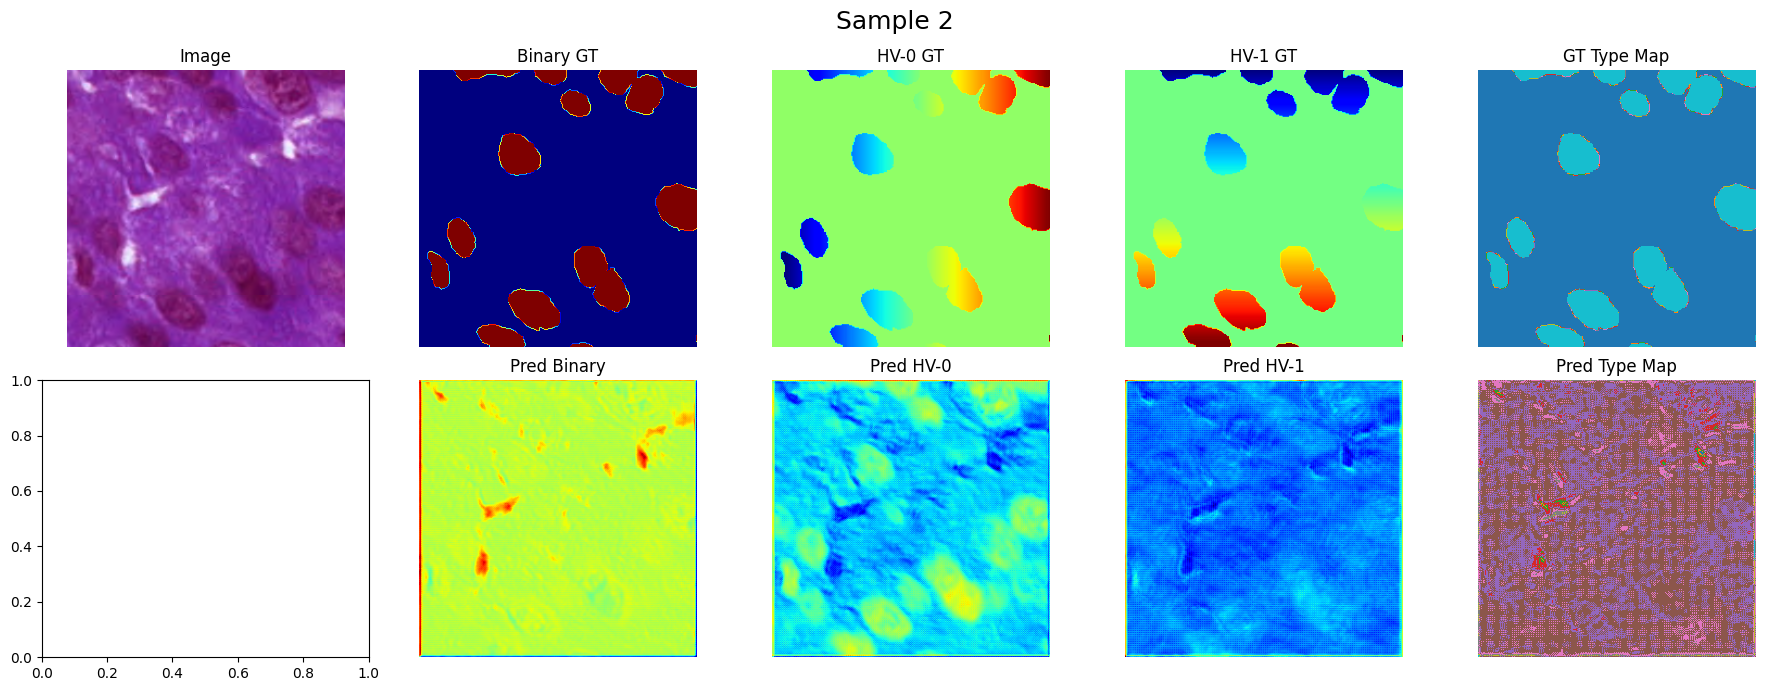

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from cellvit.models.cell_segmentation.cellvit_sam import CellViTSAM
from cellvit.training.datasets.rosie_tcga_dataset import RosieTCGADataset


DATASET_PATH = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Fusion/CellViT-plus-plus-rosie/ProcessedData_npy"
CHECKPOINT_PATH = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ROSIE_TCGA_2/logs/2025-11-30T164656_baseline_rgb_128/checkpoints/model_best.pth"

DEVICE = "cuda:1"
N_SAMPLES = 3


# Load Dataset
dataset = RosieTCGADataset(DATASET_PATH, transforms=None)
print("Dataset size:", len(dataset))


# Load Baseline Model (no Fusion Adapter)
model = CellViTSAM(
    model_path=None,
    num_nuclei_classes=6,
    num_tissue_classes=1,
    vit_structure="SAM-H",
    drop_rate=0.0,
    regression_loss=False,
)

print("Loading checkpoint:", CHECKPOINT_PATH)
state = torch.load(CHECKPOINT_PATH, map_location="cpu")
model.load_state_dict(state, strict=False)

model.to(DEVICE)
model.eval()


def show_tensor(t):
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    return t


def plot_example(img53, masks, pred, idx):
    fig, ax = plt.subplots(2, 5, figsize=(18, 7))
    fig.suptitle(f"Sample {idx}", fontsize=18)

    rgb = img53[:3].permute(1,2,0).cpu().numpy()

    ax[0,0].imshow(rgb); ax[0,0].set_title("Image"); ax[0,0].axis("off")
    ax[0,1].imshow(masks["nuclei_binary_map"], cmap="jet")
    ax[0,1].set_title("Binary GT"); ax[0,1].axis("off")
    ax[0,2].imshow(masks["hv_map"][0], cmap="jet")
    ax[0,2].set_title("HV-0 GT"); ax[0,2].axis("off")
    ax[0,3].imshow(masks["hv_map"][1], cmap="jet")
    ax[0,3].set_title("HV-1 GT"); ax[0,3].axis("off")
    ax[0,4].imshow(masks["nuclei_type_map"], cmap="tab10")
    ax[0,4].set_title("GT Type Map"); ax[0,4].axis("off")

    ax[1,1].imshow(show_tensor(pred["nuclei_binary_map"][0][0]), cmap="jet")
    ax[1,1].set_title("Pred Binary"); ax[1,1].axis("off")
    hv_pred = pred["hv_map"]
    ax[1,2].imshow(show_tensor(hv_pred[0][0]), cmap="jet")
    ax[1,2].set_title("Pred HV-0"); ax[1,2].axis("off")
    ax[1,3].imshow(show_tensor(hv_pred[0][1]), cmap="jet")
    ax[1,3].set_title("Pred HV-1"); ax[1,3].axis("off")
    ax[1,4].imshow(show_tensor(pred["nuclei_type_map"][0][0]), cmap="tab10")
    ax[1,4].set_title("Pred Type Map"); ax[1,4].axis("off")

    plt.tight_layout()
    plt.show()


# Run Predictions
for i in range(N_SAMPLES):
    img53, masks, _, _ = dataset[i]
    rgb = img53[:3].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(rgb, retrieve_tokens=False)

    plot_example(img53, masks, out, idx=i)


# Virchow

No checkpoint provided!
Loading Virchow checkpoint...
→ Found 456 encoder weights
→ Loaded encoder with message: <All keys matched successfully>


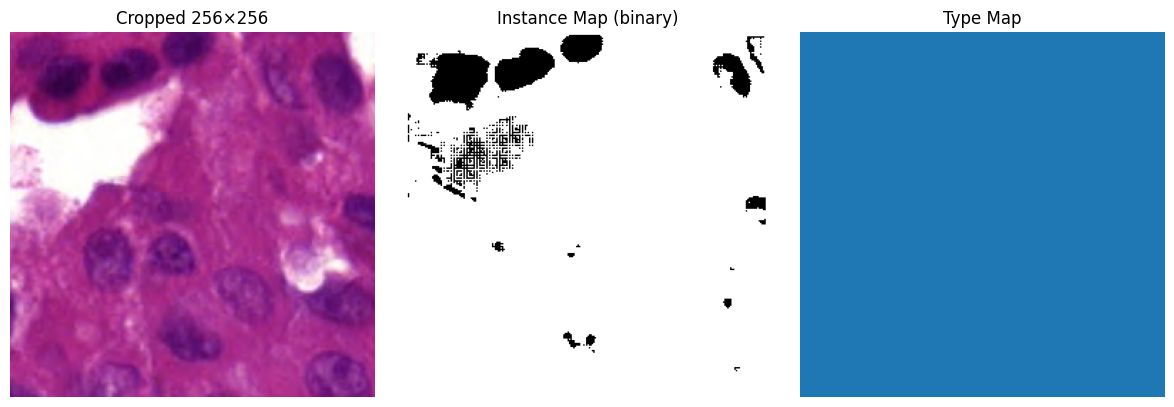

In [14]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cellvit.models.cell_segmentation.cellvit_virchow import CellViTVirchow

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------------------------------------
# 1) Paths
# ---------------------------------------------------------
ckpt_path = (
    "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/"
    "AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/checkpoints/Virchow/"
    "CellViT-Virchow-x40-AMP.pth"
)

img_path = (
    "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/"
    "AI-guided-whole-slide-imaging-analysis/ProcessedDataset/"
    "v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images/"
    "TCGA-5P-A9K0-01Z-00-DX1_1_0_0.png"
)

# ---------------------------------------------------------
# 2) Extract encoder weights from checkpoint
# ---------------------------------------------------------
def load_virchow_encoder_from_checkpoint(model, checkpoint_path):
    print("Loading Virchow checkpoint...")
    ckpt = torch.load(checkpoint_path, map_location="cpu")

    if "model_state_dict" not in ckpt:
        raise ValueError("❌ This checkpoint does not contain model_state_dict!")

    full_sd = ckpt["model_state_dict"]
    encoder_sd = {}

    # Extract only encoder.* keys
    for k, v in full_sd.items():
        if k.startswith("encoder."):
            new_k = k.replace("encoder.", "")
            encoder_sd[new_k] = v

    print("→ Found", len(encoder_sd), "encoder weights")

    msg = model.encoder.load_state_dict(encoder_sd, strict=False)
    print("→ Loaded encoder with message:", msg)


# ---------------------------------------------------------
# 3) Instantiate model (no internal pretrained path)
# ---------------------------------------------------------
model = CellViTVirchow(
    model_virchow_path=None,   # We will load manually
    num_nuclei_classes=6,
    num_tissue_classes=19,
)

load_virchow_encoder_from_checkpoint(model, ckpt_path)
model.freeze_encoder()

model.to(DEVICE)
model.eval()

# ---------------------------------------------------------
# 4) Load & center-crop image to 256×256
# ---------------------------------------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

H, W, _ = img.shape
crop_size = 256

y0 = (H - crop_size) // 2
x0 = (W - crop_size) // 2
img_crop = img[y0:y0+crop_size, x0:x0+crop_size]

# ---------------------------------------------------------
# 5) Convert to tensor & normalize [-1, 1]
# ---------------------------------------------------------
img_tensor = torch.tensor(img_crop / 255.0, dtype=torch.float32).permute(2, 0, 1)
img_tensor = (img_tensor - 0.5) / 0.5
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

# ---------------------------------------------------------
# 6) Forward pass
# ---------------------------------------------------------
with torch.no_grad():
    out = model(img_tensor)

inst_logits = out["nuclei_binary_map"][0]        # shape (2,256,256)
inst_map = inst_logits.argmax(0).cpu().numpy()   # shape (256,256)
type_map = out["nuclei_type_map"][0].argmax(0).cpu().numpy()

# ---------------------------------------------------------
# 7) Plot results
# ---------------------------------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_crop)
plt.title("Cropped 256×256")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(inst_map, cmap="gray")
plt.title("Instance Map (binary)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(type_map, cmap="tab10")
plt.title("Type Map")
plt.axis("off")

plt.tight_layout()
plt.show()


No checkpoint provided!
Loading Virchow encoder from checkpoint...
→ Using 454 encoder weights
→ load_state_dict msg: _IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


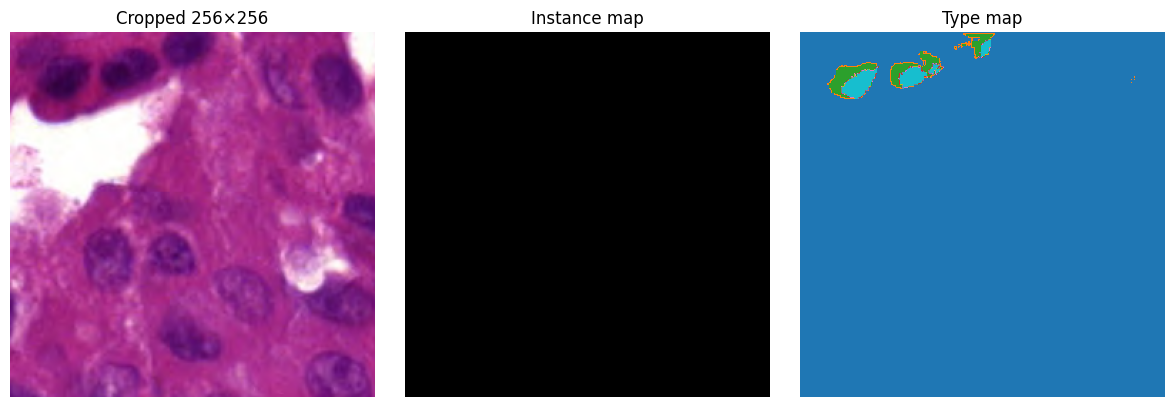

In [13]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cellvit.models.cell_segmentation.cellvit_virchow import CellViTVirchow

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------------------------------------
# Paths
# ---------------------------------------------------------
ckpt_path = (
    "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/"
    "AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/checkpoints/Virchow/"
    "CellViT-Virchow-x40-AMP.pth"
)

img_path = (
    "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/"
    "AI-guided-whole-slide-imaging-analysis/ProcessedDataset/"
    "v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images/"
    "TCGA-5P-A9K0-01Z-00-DX1_1_0_0.png"
)


# ---------------------------------------------------------
# Load ONLY encoder weights (skip decoder & heads)
# ---------------------------------------------------------
def load_virchow_encoder_from_checkpoint(model, checkpoint_path):
    print("Loading Virchow encoder from checkpoint...")

    ckpt = torch.load(checkpoint_path, map_location="cpu")
    full_sd = ckpt["model_state_dict"]

    encoder_sd = {}

    for k, v in full_sd.items():
        if not k.startswith("encoder."):
            continue  # skip non-encoder keys

        # skip classification head inside encoder
        if "encoder.head" in k:
            continue

        # rename "encoder.xxx" → "xxx"
        new_k = k.replace("encoder.", "")
        encoder_sd[new_k] = v

    print("→ Using", len(encoder_sd), "encoder weights")

    msg = model.encoder.load_state_dict(encoder_sd, strict=False)
    print("→ load_state_dict msg:", msg)


# ---------------------------------------------------------
# Instantiate Virchow model
# ---------------------------------------------------------
model = CellViTVirchow(
    model_virchow_path=None,  # we load manually
    num_nuclei_classes=6,
    num_tissue_classes=1,
)

load_virchow_encoder_from_checkpoint(model, ckpt_path)
model.freeze_encoder()
model.to(DEVICE)
model.eval()

# ---------------------------------------------------------
# Load + crop image to 256×256
# ---------------------------------------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

H, W, _ = img.shape
crop = 256
y0 = (H - crop) // 2
x0 = (W - crop) // 2
img_crop = img[y0:y0 + crop, x0:x0 + crop]

# ---------------------------------------------------------
# Convert to tensor
# ---------------------------------------------------------
img_tensor = torch.tensor(img_crop / 255.0, dtype=torch.float32).permute(2, 0, 1)
img_tensor = (img_tensor - 0.5) / 0.5
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

# ---------------------------------------------------------
# Forward
# ---------------------------------------------------------
with torch.no_grad():
    out = model(img_tensor)

inst_logits = out["nuclei_binary_map"][0]        # shape (2,256,256)
inst_map = inst_logits.argmax(0).cpu().numpy()   # shape (256,256)

type_map = out["nuclei_type_map"][0].argmax(0).cpu().numpy()

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_crop)
plt.title("Cropped 256×256")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(inst_map, cmap="gray")
plt.title("Instance map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(type_map, cmap="tab10")
plt.title("Type map")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
sd = torch.load(encoder_path, map_location="cpu")
print(sd.keys())


dict_keys(['arch', 'epoch', 'model_state_dict', 'config', 'scaler_state_dict'])


In [7]:
import torch

best_ckpt_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p128_pannuke/logs_local/2025-11-13T173728_tcga_finetune_128/checkpoints/model_best.pth"
latest_ckpt_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p128_pannuke/logs_local/2025-11-13T173728_tcga_finetune_128/checkpoints/latest_checkpoint.pth"
ckpt_path = best_ckpt_path
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)

print("=== Top-level keys ===")
print(ckpt.keys())

print("\n=== model_state_dict keys (first 30) ===")
print(list(ckpt["model_state_dict"].keys())[:30])

print("\n=== Optimizer keys ===")
print(ckpt["optimizer_state_dict"].keys())

print("\nEpoch stored:", ckpt.get("epoch"))


=== Top-level keys ===
dict_keys(['arch', 'epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_metric', 'best_epoch', 'config', 'wandb_id', 'logdir', 'run_name', 'scaler_state_dict'])

=== model_state_dict keys (first 30) ===
['encoder.pos_embed', 'encoder.patch_embed.proj.weight', 'encoder.patch_embed.proj.bias', 'encoder.blocks.0.norm1.weight', 'encoder.blocks.0.norm1.bias', 'encoder.blocks.0.attn.rel_pos_h', 'encoder.blocks.0.attn.rel_pos_w', 'encoder.blocks.0.attn.qkv.weight', 'encoder.blocks.0.attn.qkv.bias', 'encoder.blocks.0.attn.proj.weight', 'encoder.blocks.0.attn.proj.bias', 'encoder.blocks.0.norm2.weight', 'encoder.blocks.0.norm2.bias', 'encoder.blocks.0.mlp.lin1.weight', 'encoder.blocks.0.mlp.lin1.bias', 'encoder.blocks.0.mlp.lin2.weight', 'encoder.blocks.0.mlp.lin2.bias', 'encoder.blocks.1.norm1.weight', 'encoder.blocks.1.norm1.bias', 'encoder.blocks.1.attn.rel_pos_h', 'encoder.blocks.1.attn.rel_pos_w', 'encoder.blocks.1.attn.qkv.weight', 'enc

In [8]:
print(ckpt["arch"])


CellViTSAM


🧠 Loading checkpoint from: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p128_pannuke/logs_local/2025-11-13T173728_tcga_finetune_128/checkpoints/model_best.pth
✅ Model loaded successfully.


TypeError: Invalid shape (2, 128, 128) for image data

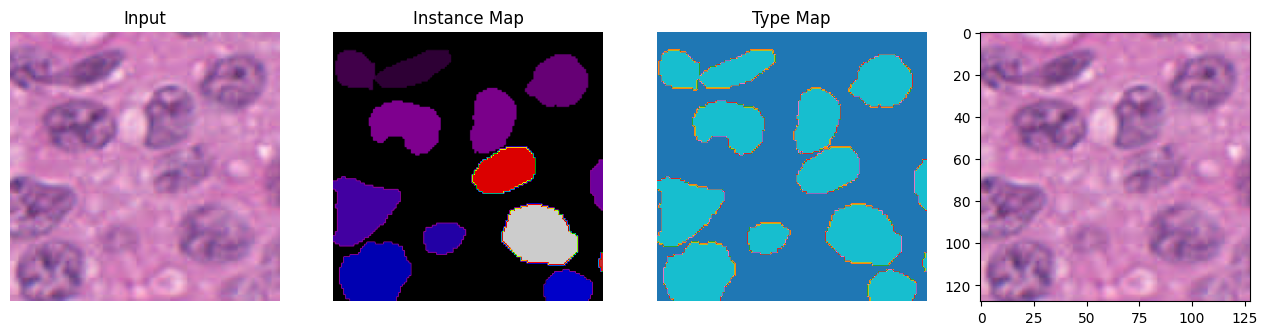

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from torchvision import transforms
from PIL import Image
import glob, os

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose experiment: "128" or "512"
PATCH_SIZE = 128  # or 512

ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis")
PROC_ROOT = ROOT / "ProcessedDataset/v1_40x_area20"
DATA_ROOT = PROC_ROOT / f"patches_cellvit_p{PATCH_SIZE}_pannuke/fold1"
CHECKPOINT_PATH = PROC_ROOT / f"patches_cellvit_p{PATCH_SIZE}_pannuke/logs_local/2025-11-11T230124_tcga_finetune_{PATCH_SIZE}/checkpoints/latest_checkpoint.pth"
CHECKPOINT_PATH = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/checkpoints/Virchow/CellViT-Virchow-x40-AMP.pth"



# --- Load model ---
from cellvit.models.cell_segmentation.cellvit_sam import CellViTSAM

model = CellViTSAM(
    model_path=None,
    num_nuclei_classes=6,
    num_tissue_classes=1,
    vit_structure="SAM-H",
    drop_rate=0.0,
    regression_loss=False,
).to(device)

print(f"🧠 Loading checkpoint from: {CHECKPOINT_PATH}")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
state_dict = checkpoint.get("state_dict", checkpoint)
model.load_state_dict(state_dict, strict=False)
model.eval()
print("✅ Model loaded successfully.")

# --- Load sample data ---
img_paths = sorted(glob.glob(str(DATA_ROOT / "images" / "*.png")))
label_paths = sorted(glob.glob(str(DATA_ROOT / "labels" / "*.npy")))
to_tensor = transforms.ToTensor()

# --- Visualization loop ---
for i in range(3):  # visualize first few
    img_path = img_paths[i]
    label_path = label_paths[i]

    img = Image.open(img_path).convert("RGB")
    label_data = np.load(label_path, allow_pickle=True).item()

    inst_map = label_data["inst_map"]
    type_map = label_data["type_map"]

    img_t = to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        pred_map = torch.sigmoid(out["nuclei_binary_map"]).cpu().squeeze().numpy()

    # --- Visualization ---
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(inst_map, cmap="nipy_spectral")
    plt.title("Instance Map")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(type_map, cmap="tab10")
    plt.title("Type Map")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(img)
    plt.imshow(pred_map > 0.5, alpha=0.5, cmap="spring")
    plt.title("Prediction Overlay")
    plt.axis("off")

    plt.suptitle(f"Patch: {Path(img_path).name}")
    plt.tight_layout()
    plt.show()


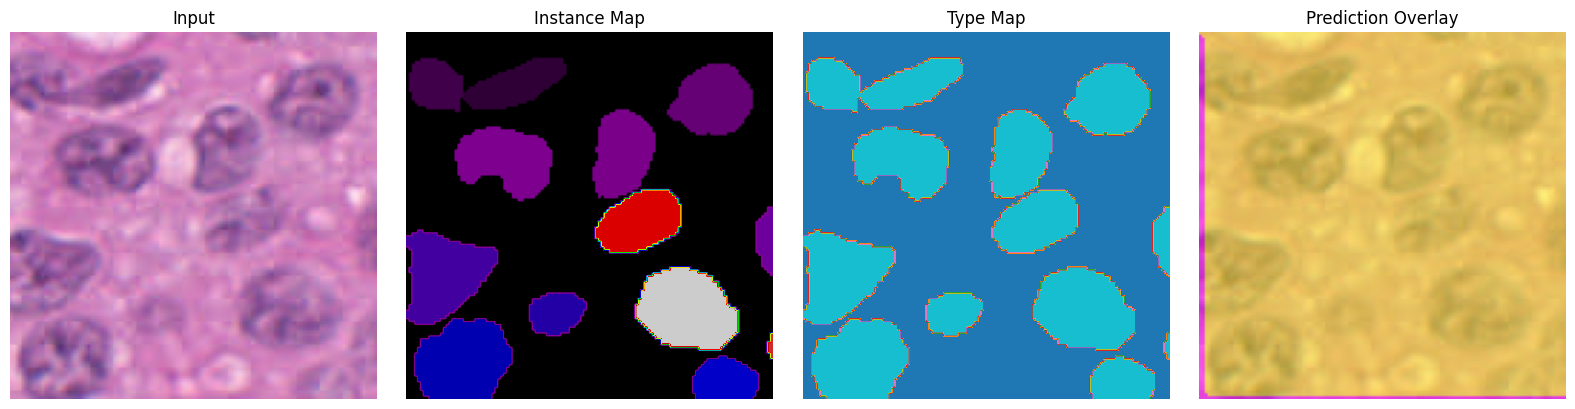

In [8]:
with torch.no_grad():
    out = model(img_t)
    pred_map = torch.sigmoid(out["nuclei_binary_map"]).cpu().squeeze().numpy()
    if pred_map.ndim == 3:  # handle (2, H, W)
        pred_map = pred_map[1]  # nuclei channel

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1); plt.imshow(img); plt.title("Input"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(inst_map, cmap="nipy_spectral"); plt.title("Instance Map"); plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(type_map, cmap="tab10"); plt.title("Type Map"); plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(img)
plt.imshow(pred_map > 0.5, alpha=0.5, cmap="spring")  # overlay
plt.title("Prediction Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()


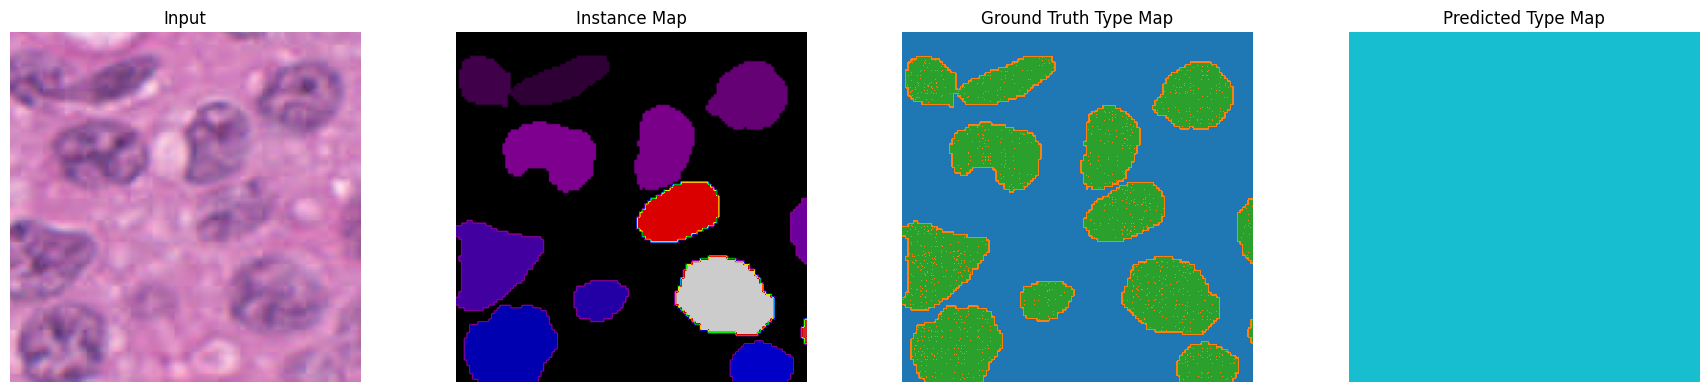

In [9]:
with torch.no_grad():
    out = model(img_t)
    # Get per-class probabilities → convert to integer map
    pred_type = torch.argmax(out["nuclei_type_map"], dim=1).cpu().squeeze().numpy()

# Define number of classes (same as in config)
num_classes = 6  

plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Input")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(inst_map, cmap="nipy_spectral")
plt.title("Instance Map")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(type_map, cmap="tab10", vmin=0, vmax=num_classes-1)
plt.title("Ground Truth Type Map")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(pred_type, cmap="tab10", vmin=0, vmax=num_classes-1)
plt.title("Predicted Type Map")
plt.axis("off")

plt.tight_layout()
plt.show()


✅ checkpoint loaded


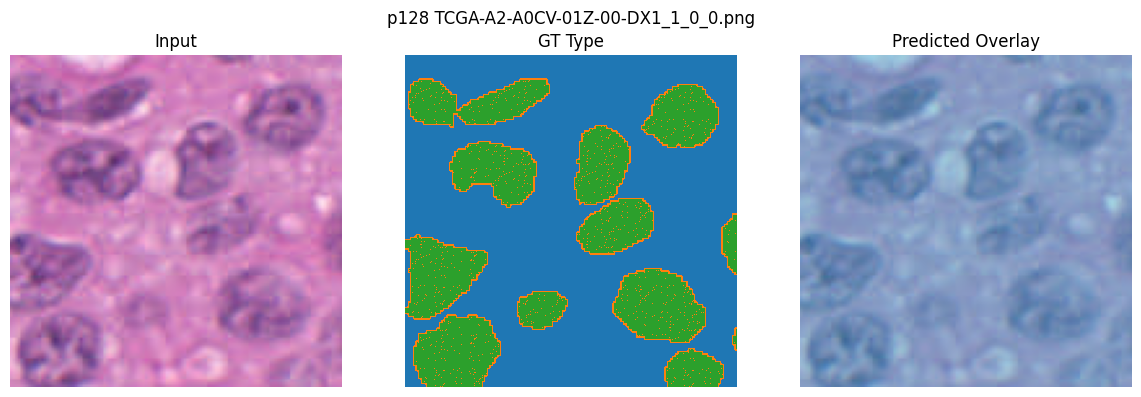

In [13]:
# --- Minimal preview without trainer & without saving ---

import os, glob
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image

# --- CONFIG (adjust these) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 128  # or 512
ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis")
PROC_ROOT = ROOT / "ProcessedDataset/v1_40x_area20"
DATA_ROOT = PROC_ROOT / f"patches_cellvit_p{PATCH_SIZE}_pannuke/fold1"
CHECKPOINT_PATH = PROC_ROOT / f"patches_cellvit_p{PATCH_SIZE}_pannuke/logs_local/2025-11-11T230124_tcga_finetune_{PATCH_SIZE}/checkpoints/latest_checkpoint.pth"
NUM_CLASSES = 6

# --- Model (same as you used) ---
from cellvit.models.cell_segmentation.cellvit_sam import CellViTSAM
model = CellViTSAM(
    model_path=None,
    num_nuclei_classes=NUM_CLASSES,
    num_tissue_classes=1,
    vit_structure="SAM-H",
    drop_rate=0.0,
    regression_loss=False,
).to(device).eval()

state = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
sd = state.get("state_dict", state)
model.load_state_dict(sd, strict=False)
print("✅ checkpoint loaded")

# --- Data pick (first sample) ---
img_paths = sorted(glob.glob(str(DATA_ROOT / "images" / "*.png")))
lab_paths = sorted(glob.glob(str(DATA_ROOT / "labels" / "*.npy")))
assert img_paths and lab_paths, "No images/labels found."

i = 0
img_p = img_paths[i]
lab_p = lab_paths[i]

img = Image.open(img_p).convert("RGB")
label = np.load(lab_p, allow_pickle=True).item()
inst_map = label["inst_map"]
type_map = label["type_map"]

to_tensor = transforms.ToTensor()
img_t = to_tensor(img).unsqueeze(0).to(device)  # [1,3,H,W]

# --- Run model ---
with torch.no_grad():
    out = model(img_t)
    # For the preview we only need 'nuclei_type_map' logits
    pred_type_logits = out["nuclei_type_map"]            # [1,C,H,W]
    pred_type_probs  = torch.softmax(pred_type_logits, dim=1)
    # keep the full [1,C,H,W] for the function below
    pred_pack = {"nuclei_type_map": pred_type_probs}

# --- Build GT pack in one-hot [1,C,H,W] ---
type_map_t = torch.from_numpy(type_map).long()          # [H,W]
gt_onehot  = F.one_hot(type_map_t, num_classes=NUM_CLASSES).permute(2,0,1).unsqueeze(0).float()  # [1,C,H,W]
gt_pack = {"nuclei_type_map": gt_onehot.to(device)}

# --- Minimal preview function (shows only; does NOT save) ---
def show_val_preview(inputs, outputs, gts, num_classes=6, title_prefix=""):
    img_np = inputs[0].detach().cpu().permute(1,2,0).numpy()
    # If your training normalized to [-1,1], uncomment the next line:
    # img_np = ((img_np * 0.5) + 0.5).clip(0,1)

    gt_type   = torch.argmax(gts["nuclei_type_map"], dim=1)[0].detach().cpu().numpy()
    pred_type = torch.argmax(outputs["nuclei_type_map"], dim=1)[0].detach().cpu().numpy()

    denom = max(num_classes - 1, 1)
    pred_rgb = (plt.get_cmap("tab10")(pred_type / denom)[:, :, :3] * 255).astype(np.uint8)
    base = (img_np * 255).astype(np.uint8)

    try:
        overlay = cv2.addWeighted(base, 0.6, pred_rgb, 0.4, 0)
    except Exception:
        overlay = pred_rgb

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np);   plt.title("Input");                 plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(gt_type,  cmap="tab10", vmin=0, vmax=num_classes-1); plt.title("GT Type"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Predicted Overlay");      plt.axis("off")
    plt.suptitle(f"{title_prefix}{Path(img_p).name}")
    plt.tight_layout()
    plt.show()

# --- Show it ---
show_val_preview(img_t, pred_pack, gt_pack, num_classes=NUM_CLASSES, title_prefix=f"p{PATCH_SIZE} ")


In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path(PROC_ROOT) / f"patches_cellvit_p{PATCH_SIZE}_pannuke/preview_out"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# After you compute `out = model(img_t)`:
with torch.no_grad():
    pred_type = torch.argmax(out["nuclei_type_map"], dim=1)[0].cpu().numpy().astype(np.uint8)  # [H,W]

stem = Path(img_path).stem

# 1) Save RAW IDs (best for metrics & reproducibility)
np.save(SAVE_DIR / f"{stem}_pred_type.npy", pred_type)

# 2) Save COLORED PNG (for quick visual QC; same colors every time)
#    Use a fixed palette (tab10) across [0..NUM_CLASSES-1]
denom = max(NUM_CLASSES - 1, 1)
colored = (plt.get_cmap("tab10")(pred_type / denom)[:, :, :3] * 255).astype(np.uint8)  # [H,W,3]
Image.fromarray(colored).save(SAVE_DIR / f"{stem}_pred_type.png")

# (Optional) 3) Also save an overlay for presentations
#    (comment out if you don't want it)
overlay = Image.fromarray(np.array(img).astype(np.uint8)).convert("RGBA")
mask_rgba = Image.fromarray(colored).convert("RGBA")
mask_rgba.putalpha(110)  # ~0.43 alpha
overlay = Image.alpha_composite(overlay, mask_rgba).convert("RGB")
overlay.save(SAVE_DIR / f"{stem}_overlay.png")

print(f"Saved:\n- {SAVE_DIR / f'{stem}_pred_type.npy'}\n- {SAVE_DIR / f'{stem}_pred_type.png'}\n- {SAVE_DIR / f'{stem}_overlay.png'} (optional)")


Saved:
- /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p128_pannuke/preview_out/TCGA-A2-A0CV-01Z-00-DX1_1_0_0_pred_type.npy
- /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p128_pannuke/preview_out/TCGA-A2-A0CV-01Z-00-DX1_1_0_0_pred_type.png
- /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p128_pannuke/preview_out/TCGA-A2-A0CV-01Z-00-DX1_1_0_0_overlay.png (optional)


In [ ]:
save_dir = CHECKPOINT_PATH.parent / "quick_previews"
os.makedirs(save_dir, exist_ok=True)
num_classes = 6  # match your config

for i in range(3):  # visualize first few
    img_path = img_paths[i]
    label_path = label_paths[i]

    img = Image.open(img_path).convert("RGB")
    label_data = np.load(label_path, allow_pickle=True).item()
    inst_map = label_data["inst_map"]
    type_map = label_data["type_map"].astype(np.int64)  # [H,W] class ids

    img_t = to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)

        # Binary overlay (what you already had)
        pred_bin = torch.sigmoid(out["nuclei_binary_map"]).cpu().squeeze().numpy()

        # ---- For save_val_preview: build the minimal dicts it needs ----
        # Model logits -> softmax over classes
        pred_type_soft = torch.softmax(out["nuclei_type_map"], dim=1)

        # GT one-hot [1,C,H,W]
        gt_onehot = torch.nn.functional.one_hot(
            torch.from_numpy(type_map), num_classes=num_classes
        ).permute(2, 0, 1).unsqueeze(0).float().to(device)

        # Important: save_val_preview expects inputs normalized to ~[-1,1]
        # so we pre-normalize here (it will "undo" inside):
        inputs_for_viz = (img_t - 0.5) / 0.5

        save_val_preview(
            inputs=inputs_for_viz.detach().cpu(),                   # (1,3,H,W)
            outputs={"nuclei_type_map": pred_type_soft.detach()},   # (1,C,H,W)
            gts={"nuclei_type_map": gt_onehot.detach()},            # (1,C,H,W)
            epoch=0,                                                # ad-hoc test
            save_dir=str(save_dir),
            num_classes=num_classes,
            index=i,                                                # separate files
        )

    # --- Your on-screen matplotlib preview ---
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1); plt.imshow(img); plt.title("Input"); plt.axis("off")
    plt.subplot(1, 4, 2); plt.imshow(inst_map, cmap="nipy_spectral"); plt.title("Instance Map"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.imshow(type_map, cmap="tab10", vmin=0, vmax=num_classes-1); plt.title("Type Map"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.imshow(img); plt.imshow(pred_bin > 0.5, alpha=0.5, cmap="spring"); plt.title("Prediction Overlay"); plt.axis("off")
    plt.suptitle(f"Patch: {Path(img_path).name}")
    plt.tight_layout(); plt.show()

print(f"✅ Wrote previews to: {save_dir}")


In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import glob, os

# --- Paths ---
checkpoint_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/logs_local/2025-11-10T172321_tcga_finetune_512/checkpoints/latest_checkpoint.pth"
val_images_dir = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images"
val_labels_dir = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/labels"

from cellvit.models.cell_segmentation.cellvit_sam import CellViTSAM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Create model instance ---
model = CellViTSAM(
    model_path=None,                # no need to load SAM weights manually now
    num_nuclei_classes=6,           # as in your config
    num_tissue_classes=1,
    vit_structure="SAM-H",          # from your config
    drop_rate=0.0,
    regression_loss=False,
).to(device)

# --- Load fine-tuned weights ---
checkpoint = torch.load(checkpoint_path, map_location=device)
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"], strict=False)
else:
    model.load_state_dict(checkpoint, strict=False)

model.eval()


# --- Load samples ---
img_paths = sorted(glob.glob(os.path.join(val_images_dir, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(val_labels_dir, "*.png")))

to_tensor = transforms.ToTensor()

for i in range(3):  # visualize a few patches
    img = Image.open(img_paths[i]).convert("RGB")
    mask = Image.open(mask_paths[i]).convert("L")
    img_t = to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        pred = torch.sigmoid(out["nuclei_binary_map"]).cpu().squeeze().numpy()

    # --- Overlay visualization ---
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(img); plt.imshow(pred>0.5, alpha=0.5, cmap="spring"); plt.title("Overlay Prediction"); plt.axis("off")
    plt.tight_layout(); plt.show()


IndexError: list index out of range

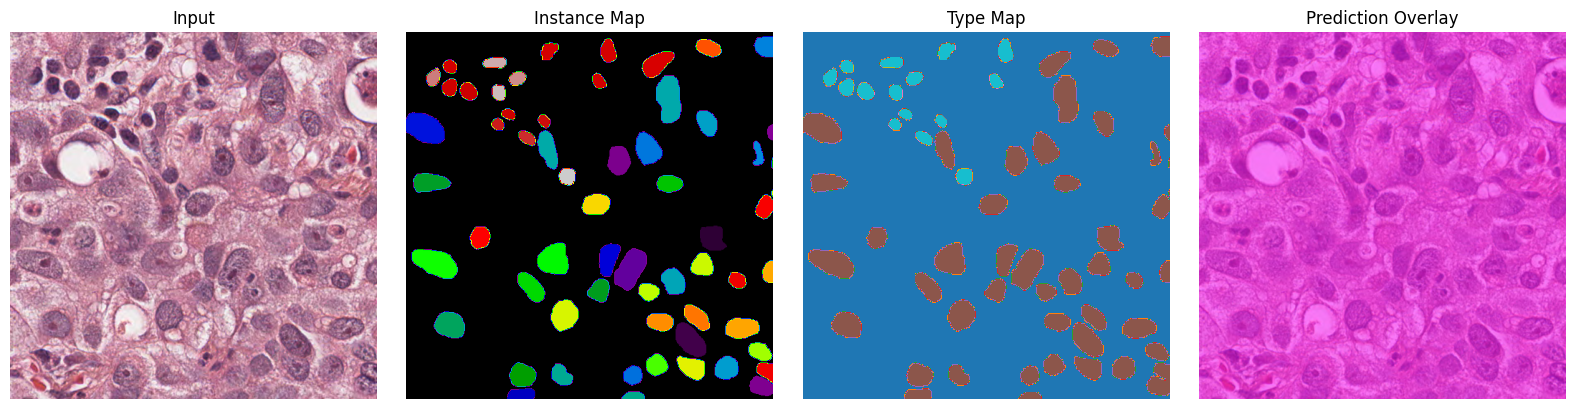

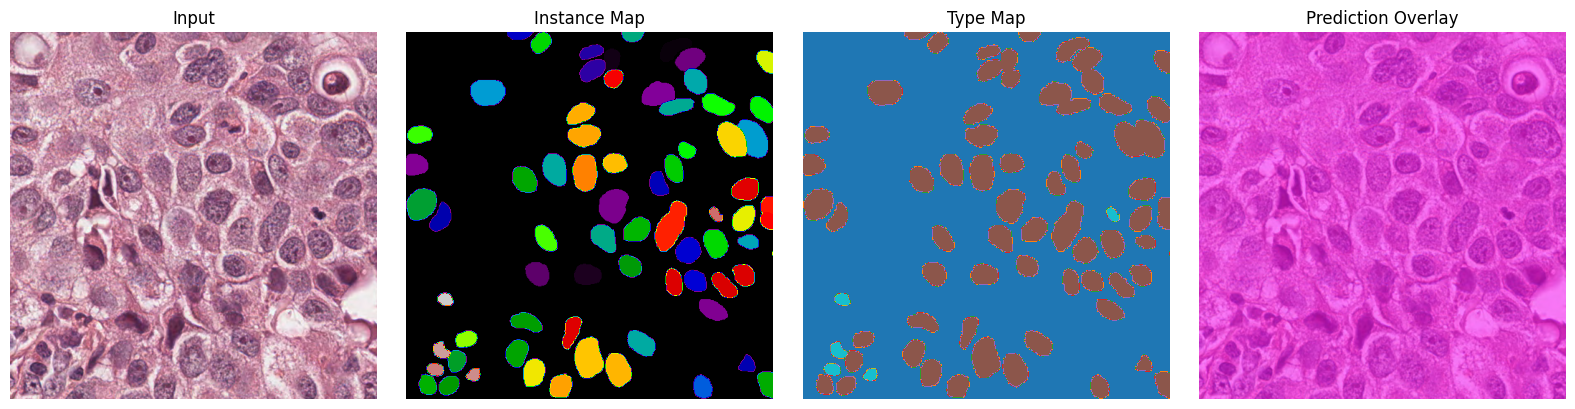

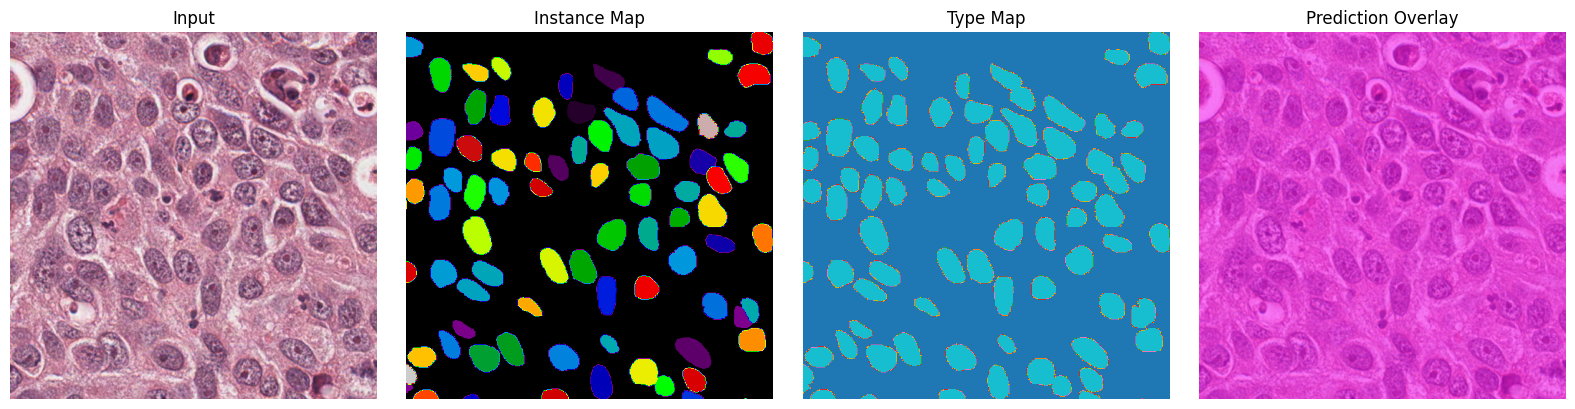

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import glob, os

# --- Paths ---
checkpoint_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/logs_local/2025-11-10T172321_tcga_finetune_512/checkpoints/latest_checkpoint.pth"
val_images_dir = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images"
val_labels_dir = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/labels"

# --- Load model ---
from cellvit.models.cell_segmentation.cellvit_sam import CellViTSAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CellViTSAM(
    model_path=None,
    num_nuclei_classes=6,
    num_tissue_classes=1,
    vit_structure="SAM-H",
    drop_rate=0.0,
    regression_loss=False,
).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = checkpoint.get("state_dict", checkpoint)
model.load_state_dict(state_dict, strict=False)
model.eval()

# --- Load samples ---
img_paths = sorted(glob.glob(os.path.join(val_images_dir, "*.png")))
label_paths = sorted(glob.glob(os.path.join(val_labels_dir, "*.npy")))

to_tensor = transforms.ToTensor()

for i in range(3):  # visualize first few
    img = Image.open(img_paths[i]).convert("RGB")
    label_data = np.load(label_paths[i], allow_pickle=True).item()

    inst_map = label_data["inst_map"]
    type_map = label_data["type_map"]

    img_t = to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        pred = torch.sigmoid(out["nuclei_binary_map"]).cpu().squeeze().numpy()

    # --- Visualize ---
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1); plt.imshow(img); plt.title("Input"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(inst_map, cmap="nipy_spectral"); plt.title("Instance Map"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(type_map, cmap="tab10"); plt.title("Type Map"); plt.axis("off")
    plt.subplot(1,4,4)
    plt.imshow(img)
    plt.imshow(pred[1] > 0.5, alpha=0.5, cmap="spring")
    plt.title("Prediction Overlay")
    plt.axis("off")

    plt.tight_layout(); plt.show()


In [25]:
pred


array([[[0.48034573, 0.4801933 , 0.4797112 , ..., 0.47990024,
         0.47977573, 0.47999382],
        [0.48051846, 0.48026153, 0.48037115, ..., 0.4802685 ,
         0.47974005, 0.4799195 ],
        [0.48021793, 0.48029897, 0.47948417, ..., 0.47984928,
         0.4793831 , 0.479463  ],
        ...,
        [0.48041537, 0.48002392, 0.4786372 , ..., 0.47935122,
         0.47897843, 0.47937554],
        [0.4802268 , 0.4802318 , 0.47926632, ..., 0.47903863,
         0.47891206, 0.47893435],
        [0.48051572, 0.4794005 , 0.4785597 , ..., 0.47909015,
         0.47862917, 0.4787568 ]],

       [[0.49740985, 0.49706274, 0.49812308, ..., 0.49867877,
         0.49847698, 0.49888343],
        [0.49695414, 0.49658325, 0.49813977, ..., 0.49868882,
         0.49903533, 0.49949208],
        [0.49549136, 0.49497986, 0.496109  , ..., 0.4979004 ,
         0.49790874, 0.4991854 ],
        ...,
        [0.4961224 , 0.49615508, 0.4967543 , ..., 0.49725363,
         0.4968781 , 0.49894407],
        [0.4

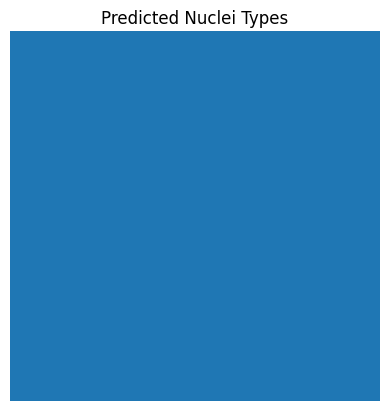

In [18]:
type_pred = out["nuclei_type_map"].softmax(dim=1).argmax(dim=1).cpu().squeeze().numpy()
plt.imshow(type_pred, cmap="tab10")
plt.title("Predicted Nuclei Types")
plt.axis("off")
plt.show()


In [19]:
out = model(img_t)
print("nuclei_type_map shape:", out["nuclei_type_map"].shape)
print("min/max:", out["nuclei_type_map"].min().item(), out["nuclei_type_map"].max().item())


nuclei_type_map shape: torch.Size([1, 6, 512, 512])
min/max: -0.08719339966773987 0.11651643365621567


In [20]:
import numpy as np, glob, os
import itertools

label_paths = glob.glob("/.../labels/*.npy")
unique_vals = set()
for path in itertools.islice(label_paths, 10):  # sample a few
    m = np.load(path, allow_pickle=True).item()["type_map"]
    unique_vals.update(np.unique(m).tolist())
print("Unique type labels found:", unique_vals)


Unique type labels found: set()


In [15]:
print("Images:", len(img_paths))
print("Labels:", len(mask_paths))
print("First few image paths:", img_paths[:3])
print("First few label paths:", mask_paths[:3])


Images: 200
Labels: 0
First few image paths: ['/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images/TCGA-55-1594-01Z-00-DX1_001_0_0.png', '/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images/TCGA-55-1594-01Z-00-DX1_001_0_512.png', '/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke/fold0/images/TCGA-55-1594-01Z-00-DX1_001_512_0.png']
First few label paths: []


In [3]:
from cellvit.training.datasets.segmentation_dataset import SegmentationDataset

dataset = SegmentationDataset(
    dataset_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_segmentation",
    split="train",
)
dataset.cache_dataset()

img, detections, types, name = dataset[0]
print(name, len(detections), len(types))


100%|██████████| 200/200 [00:20<00:00,  9.71it/s]

TCGA-55-1594-01Z-00-DX1_001_0_0 62 62


In [14]:
from cellvit.training.datasets.pannuke import PanNukeDataset

dataset_pannuke = PanNukeDataset(
    dataset_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke",
    folds=[0]
)
#dataset_pannuke.cache_dataset()

img, detections, types, name = dataset_pannuke[0]
print(name, len(detections), len(types))


TCGA-5P-A9K0-01Z-00-DX1_1_0_0.png 4 4


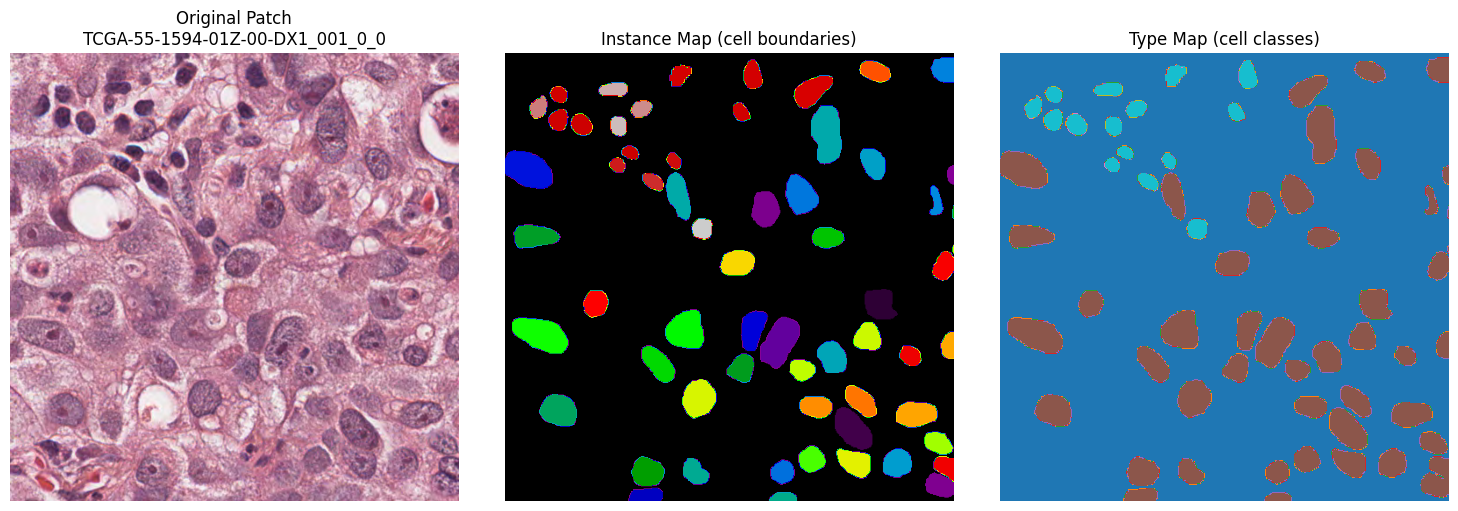

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

dataset_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_segmentation"
split = "train"
# === Pick a sample (use the one that printed earlier, or a random one) ===
sample_name = "TCGA-55-1594-01Z-00-DX1_001_0_0"  # change if needed
img = dataset.cache_images[sample_name]
annotation_path =  os.path.join(dataset_path,
    split,  "labels", f"{sample_name}.npy"
    )

data = np.load(annotation_path, allow_pickle=True).item()
inst_map = data["inst_map"]
type_map = data["type_map"]

# === Visualization ===
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title(f"Original Patch\n{sample_name}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(inst_map, cmap="nipy_spectral")
plt.title("Instance Map (cell boundaries)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(type_map, cmap="tab10")
plt.title("Type Map (cell classes)")
plt.axis("off")

plt.tight_layout()
plt.show()


Item types/len: <class 'tuple'> 4
meta type/keys: <class 'dict'> ['instance_map', 'nuclei_type_map', 'nuclei_binary_map', 'hv_map']
extra2 type: <class 'str'>
extra3 type: <class 'str'>


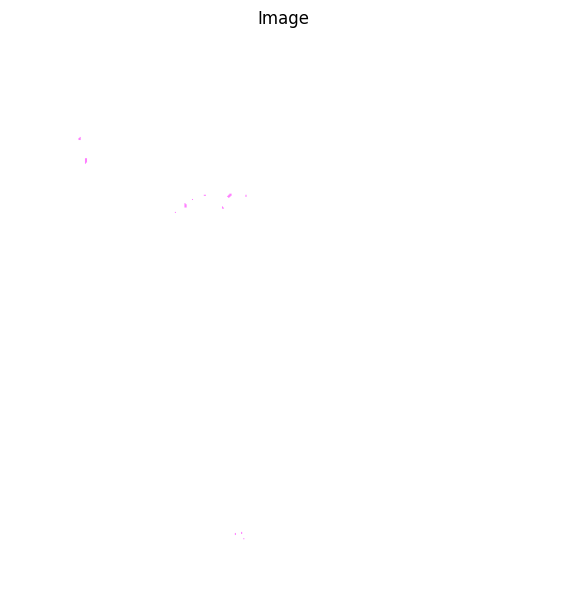

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

def denorm(img):
    # img: [C,H,W] in [-1,1] due to mean=std=0.5
    img = img.float()
    img = img * 0.5 + 0.5
    img = (img.clamp(0,1) * 255).byte()
    return img.permute(1,2,0).cpu().numpy()  # HWC uint8

def show_overlay(img_hwc, type_map_2d, num_classes=6, alpha=0.35, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img_hwc)
    cmap = cm.get_cmap('tab10', num_classes)
    overlay = np.zeros_like(img_hwc, dtype=np.uint8)
    for c in range(1, num_classes):
        m = (type_map_2d == c)
        if m.any():
            color = (np.array(cmap(c)[:3]) * 255).astype(np.uint8)
            overlay[m] = color
    plt.imshow(overlay, alpha=alpha)
    plt.axis('off')
    if title: plt.title(title)
    plt.tight_layout(); plt.show()

def show_instance(img_hwc, inst_map_2d, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img_hwc)
    plt.imshow(inst_map_2d, cmap='nipy_spectral', alpha=0.4)
    plt.axis('off')
    if title: plt.title(title)
    plt.tight_layout(); plt.show()

# ---- Inspect one PanNuke item ----
item = dataset_pannuke[0]
print("Item types/len:", type(item), len(item) if isinstance(item, (list, tuple)) else None)

img = item[0]
if isinstance(img, torch.Tensor) and img.ndim == 4 and img.shape[0] == 1:
    img = img.squeeze(0)  # [3,H,W]
assert img.ndim == 3 and img.shape[0] == 3, f"Unexpected image shape: {img.shape}"
img_hwc = denorm(img)

meta = item[1]
print("meta type/keys:", type(meta), list(meta.keys()) if isinstance(meta, dict) else None)

extra2 = item[2]
extra3 = item[3]
print("extra2 type:", type(extra2))
print("extra3 type:", type(extra3))

# Try common keys that PanNuke-like loaders use:
inst_map = None
type_map = None

if isinstance(meta, dict):
    # Look for likely keys (adapt to the actual names printed above)
    for k in meta.keys():
        v = meta[k]
        if isinstance(v, np.ndarray):
            print(f"meta[{k}] -> shape {v.shape}, dtype {v.dtype}, min/max {v.min()}/{v.max()}")
    # Heuristics
    if 'inst_map' in meta and isinstance(meta['inst_map'], np.ndarray) and meta['inst_map'].ndim == 2:
        inst_map = meta['inst_map']
    if 'type_map' in meta and isinstance(meta['type_map'], np.ndarray):
        # could be HxW or HxWxC; if one-hot, convert to argmax
        if meta['type_map'].ndim == 3:
            type_map = meta['type_map'].argmax(axis=-1)
        else:
            type_map = meta['type_map']
    # Some variants use 'nuclei_type_map' possibly as one-hot
    if type_map is None and 'nuclei_type_map' in meta and isinstance(meta['nuclei_type_map'], np.ndarray):
        ntm = meta['nuclei_type_map']
        type_map = ntm.argmax(axis=-1) if ntm.ndim == 3 else ntm

# Visualize what we found
plt.figure(figsize=(6,6))
plt.imshow(img_hwc); plt.axis('off'); plt.title("Image"); plt.tight_layout(); plt.show()

if inst_map is not None:
    show_instance(img_hwc, inst_map, title="Instance overlay")

if type_map is not None:
    show_overlay(img_hwc, type_map, num_classes=6, title="Type map overlay")


(-0.5, 511.5, 511.5, -0.5)

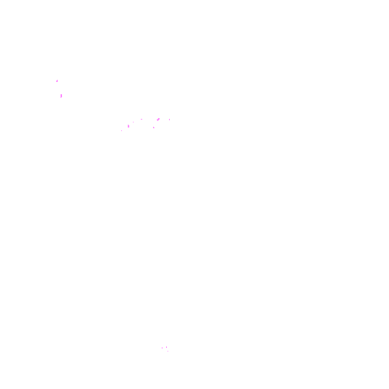

In [19]:
import torch, numpy as np, matplotlib.pyplot as plt

def denorm_to_hwc_uint8(img_3chw: torch.Tensor):
    img = img_3chw.float() * 0.5 + 0.5          # [-1,1] -> [0,1]
    return (img.clamp(0,1).permute(1,2,0).cpu().numpy() * 255).astype("uint8")


img = item[0]
if img.ndim == 4 and img.shape[0] == 1: img = img.squeeze(0)
img_hwc = denorm_to_hwc_uint8(img)
plt.imshow(img_hwc); plt.axis("off")



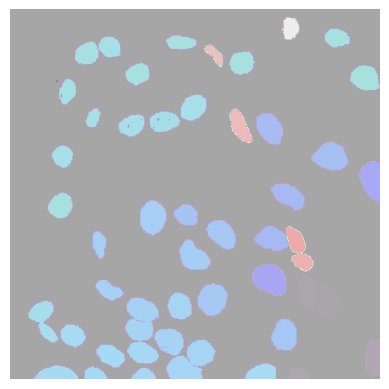

In [20]:
item = dataset_pannuke[0]
img = item[0]
if img.ndim == 4 and img.shape[0] == 1: img = img.squeeze(0)
img_hwc = denorm_to_hwc_uint8(img)

meta = item[1]
inst = meta["instance_map"]
ntm  = meta["nuclei_type_map"]
type_map = ntm.argmax(-1) if ntm.ndim == 3 else ntm

plt.imshow(img_hwc); plt.imshow(inst, cmap="nipy_spectral", alpha=0.35); plt.axis("off"); plt.show()


In [26]:
import numpy as np
from pathlib import Path

root = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_pannuke")  # ← no comma

any_npy = next(root.rglob("labels/*.npy"))  # finds one .npy anywhere under labels/
d = np.load(any_npy, allow_pickle=True).item()
print("instance_map:", d["inst_map"].shape)
print("nuclei_type_map:", d["type_map"].shape)


instance_map: (512, 512)
nuclei_type_map: (512, 512)


In [30]:
from torch.utils.data import DataLoader
from cellvit.training.datasets.pannuke import PanNukeDataset

ds = PanNukeDataset(dataset_path=root, folds=[0])
dl = DataLoader(ds, batch_size=2, shuffle=False, num_workers=0)

batch = next(iter(dl))
img, meta, tissue, name = batch
print("img:", img.shape)                       # expect [B, 3, 512, 512]
print("instance_map:", meta["instance_map"].shape)   # expect [B, 512, 512]
print("nuclei_type_map:", meta["nuclei_type_map"].shape) # expect [B, 512, 512] OR [B, 512, 512, C]


img: torch.Size([2, 3, 512, 512])
instance_map: torch.Size([2, 512, 512])
nuclei_type_map: torch.Size([2, 512, 512])


In [29]:
print(meta)

{'instance_map': tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ..., 241, 241, 241],
         [  0,   0,   0,  ..., 241, 241, 241],
         [  0,   0,   0,  ..., 241, 241, 241]]]), 'nuclei_type_map': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..

In [24]:
print(d)

{'inst_map': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 'type_map': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}


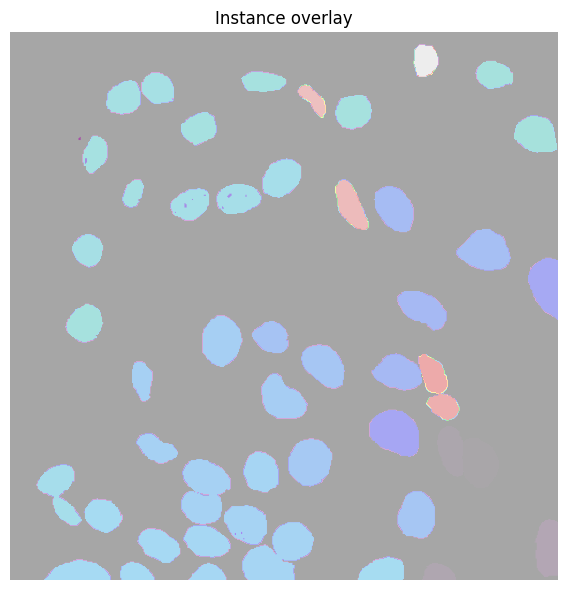

/scratch/1326323.1.academic-gpu/ipykernel_3042292/2504671188.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", int(num_classes))


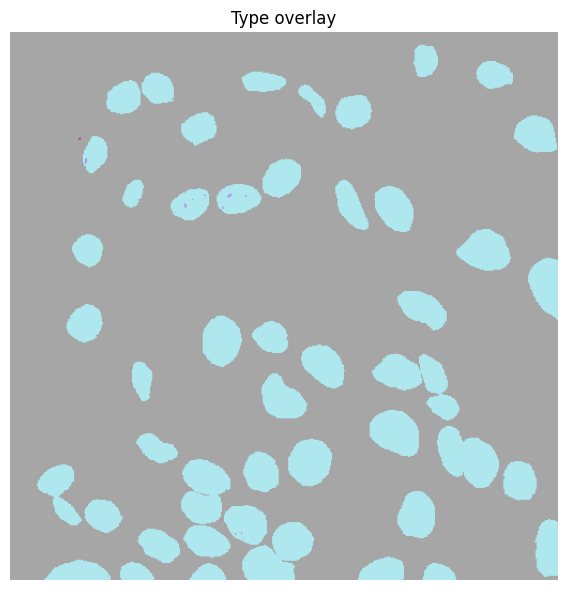

In [18]:
from matplotlib import cm

meta = item[1]
inst = meta["instance_map"]                    # HxW ints
ntm  = meta["nuclei_type_map"]                 # either HxW (labels) or HxWxC (one-hot)

# Make a class map (HxW) if it's one-hot:
if ntm.ndim == 3:
    type_map = ntm.argmax(axis=-1)
else:
    type_map = ntm

# Instance overlay
plt.figure(figsize=(6,6))
plt.imshow(img_hwc)
plt.imshow(inst, cmap="nipy_spectral", alpha=0.35)
plt.title("Instance overlay")
plt.axis("off"); plt.tight_layout(); plt.show()

# Type overlay (skip background=0)
num_classes = type_map.max() + 1
cmap = cm.get_cmap("tab10", int(num_classes))
overlay = np.zeros_like(img_hwc)
for c in range(1, int(num_classes)):
    m = (type_map == c)
    if m.any():
        overlay[m] = (np.array(cmap(c)[:3]) * 255).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(img_hwc)
plt.imshow(overlay, alpha=0.35)
plt.title("Type overlay")
plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

dataset_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512_segmentation"
split = "train"
# === Pick a sample (use the one that printed earlier, or a random one) ===
sample_name = "TCGA-55-1594-01Z-00-DX1_001_0_0"  # change if needed
img = dataset.cache_images[sample_name]
annotation_path =  os.path.join(dataset_path,
    split,  "labels", f"{sample_name}.npy"
    )

data = np.load(annotation_path, allow_pickle=True).item()
inst_map = data["inst_map"]
type_map = data["type_map"]

# === Visualization ===
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title(f"Original Patch\n{sample_name}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(inst_map, cmap="nipy_spectral")
plt.title("Instance Map (cell boundaries)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(type_map, cmap="tab10")
plt.title("Type Map (cell classes)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
import torch
from torch.utils.data import DataLoader
# import the exact Dataset class you use in training, and instantiate it
# Example if you use the repo's PanNuke dataset wrapper:
# ds = PanNukeDataset(root=..., folds=[0], transforms=..., ...)

# Or if you use SegmentationDataset directly:
# from cellvit.training.datasets.segmentation_dataset import SegmentationDataset
# ds = SegmentationDataset(dataset_path=..., split="train", filelist_path=..., transforms=...)

dl = DataLoader(dataset_pannuke, batch_size=1, shuffle=False,
                collate_fn=getattr(dataset_pannuke, "collate_batch", None))

batch = next(iter(dl))

def shape_of(x):
    return getattr(x, "shape", None)

if isinstance(batch, dict):
    for k, v in batch.items():
        print(k, type(v), shape_of(v))
else:
    # many datasets return a tuple; just print everything
    for i, v in enumerate(batch):
        print(i, type(v), shape_of(v))


0 <class 'torch.Tensor'> torch.Size([1, 3, 512, 512])
1 <class 'dict'> None
2 <class 'tuple'> None
3 <class 'tuple'> None


In [3]:
from cellvit.training.experiments.experiment_cell_classifier import ExperimentCellVitClassifier


In [7]:
ckpt_path = os.path.join(project_root,
    "logs_local", "2025-11-02T213346_cellvit++", "checkpoints", "model_best.pth"
    )

config_path = os.path.join(project_root,
    "logs_local", "2025-11-02T213346_cellvit++", "config.yaml"
    )

print("Checkpoint path:", ckpt_path)
print("Config path:", config_path)

Checkpoint path: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/logs_local/2025-11-02T213346_cellvit++/checkpoints/model_best.pth
Config path: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/logs_local/2025-11-02T213346_cellvit++/config.yaml


In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from einops import rearrange
from cellvit.inference.postprocessing_cupy import DetectionCellPostProcessorCupy
from cellvit.models.cell_segmentation.cellvit_256 import CellViT256
from cellvit.models.classifier.linear_classifier import LinearClassifier

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/test/images/TCGA-5P-A9K0-01Z-00-DX1_1_0_0.png"
cellvit_ckpt = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/checkpoints/HIPT-256/CellViT-256-x40-AMP.pth"
cellvit_ckpt = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/logs_local/2025-11-10T172321_tcga_finetune_512/checkpoints/latest_checkpoint.pth"

classifier_ckpt = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/logs_local/2025-11-03T224442_cellvit++/checkpoints/model_best.pth"

# --- Load backbone ---
cellvit = CellViT256(model256_path=cellvit_ckpt, num_nuclei_classes=6, num_tissue_classes=1)
state = torch.load(cellvit_ckpt, map_location=device)
cellvit.load_state_dict(state, strict=False)
cellvit.eval().to(device)

# --- Load classifier ---
classifier = LinearClassifier(embed_dim=384, hidden_dim=256, num_classes=6, drop_rate=0.1)
classifier.load_state_dict(torch.load(classifier_ckpt, map_location=device)["model_state_dict"])
classifier.eval().to(device)

# --- Preprocess image ---
img = Image.open(image_path).convert("RGB").resize((512, 512))
img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255
img_tensor = img_tensor.unsqueeze(0).to(device)

# --- Predict nuclei and extract tokens ---
with torch.no_grad():
    preds = cellvit(img_tensor, retrieve_tokens=True)
    print(preds.keys())
    for k, v in preds.items():
        if torch.is_tensor(v):
            print(k, v.shape)

    #Need to permute, but why?? 
    preds["nuclei_binary_map"] = preds["nuclei_binary_map"].permute(0, 2, 3, 1)
    preds["hv_map"]            = preds["hv_map"].permute(0, 2, 3, 1)
    preds["nuclei_type_map"]   = preds["nuclei_type_map"].permute(0, 2, 3, 1)


    preds["nuclei_type_map"] = torch.softmax(preds["nuclei_type_map"], dim=1)
    post = DetectionCellPostProcessorCupy(wsi=None, nr_types=6)
    post = DetectionCellPostProcessorCupy(
        wsi=None,
        nr_types=6,
    )
    post._thresh_binary = 0.005   # was 0.1, now much lower
    post._thresh_foreground = 0.005

    post._min_area = 5             # default is ~30
    post._max_area = 20000         # avoid filtering large

    post._thresh_binary = 0.1
    post._thresh_foreground = 0.05
    post._min_area = 30
    post._max_area = 20000

    

    bin_map = preds["nuclei_binary_map"][0, :, :, 1].detach().cpu().numpy()
    plt.imshow(bin_map, cmap="magma")
    plt.title("Raw Nuclei Binary Map (foreground channel)")
    plt.colorbar()
    plt.show()
    print("Binary map min/max:", bin_map.min(), bin_map.max())

    # --- Ensure proper layout (B, H, W, C) ---
    def fix_layout(x):
        arr = x.detach().cpu().numpy()
        if arr.ndim == 4:
            # Detect channel position automatically
            b, d1, d2, d3 = arr.shape
            if d1 == 2 or d1 == 6:  # (B, C, H, W)
                arr = np.transpose(arr, (0, 2, 3, 1))
            elif d3 == 2 or d3 == 6:  # (B, H, W, C) already correct
                pass
            elif d2 == 2 or d2 == 6:  # (B, H, C, W) -> fix it
                arr = np.transpose(arr, (0, 1, 3, 2))
        return arr

    # Normalize binary map to [0, 1]
    bm = preds["nuclei_binary_map"]
    bm_min, bm_max = bm.min(), bm.max()
    preds["nuclei_binary_map"] = (bm - bm_min) / (bm_max - bm_min)
    print("Rescaled binary map range:", preds["nuclei_binary_map"].min(), preds["nuclei_binary_map"].max())

    preds["hv_map"] = fix_layout(preds["hv_map"])
    preds["nuclei_type_map"] = fix_layout(preds["nuclei_type_map"])

    print("Fixed shapes:")
    for k in ["nuclei_binary_map", "hv_map", "nuclei_type_map"]:
        print(k, preds[k].shape)


    # --- Normalize binary map for visibility ---
    bin_map = preds["nuclei_binary_map"][0, :, :, 1]
    bin_map = (bin_map - bin_map.min()) / (bin_map.max() - bin_map.min() + 1e-8)
    preds["nuclei_binary_map"][0, :, :, 1] = bin_map

    # --- Adaptive thresholding ---
    adaptive_thresh = bin_map.mean() + 0.5 * bin_map.std()
    post._thresh_binary = adaptive_thresh
    post._thresh_foreground = adaptive_thresh
    print(f"Using adaptive threshold: {adaptive_thresh:.4f}")

    # Ensure correct binary map shape
    print("Before fix:", preds["nuclei_binary_map"].shape)

    # If it's (B,2,H,W), move channels to the end → (B,H,W,2)
    if preds["nuclei_binary_map"].shape[1] == 2:
        preds["nuclei_binary_map"] = np.moveaxis(preds["nuclei_binary_map"], 1, -1)

    # Same for hv_map (which must be (B,H,W,2))
    if preds["hv_map"].shape[1] == 2:
        preds["hv_map"] = np.moveaxis(preds["hv_map"], 1, -1)

    # nuclei_type_map should be (B,H,W,C) with C=num_classes
    if preds["nuclei_type_map"].shape[1] == 6:
        preds["nuclei_type_map"] = np.moveaxis(preds["nuclei_type_map"], 1, -1)

    print("After fix:")
    print("binary:", preds["nuclei_binary_map"].shape)
    print("hv:", preds["hv_map"].shape)
    print("type:", preds["nuclei_type_map"].shape)

    # --- Postprocess ---
    inst_map, cell_pred_dict = post.post_process_batch(preds)
    print("Detected cells:", len(cell_pred_dict[0]))


# --- Extract cell tokens ---
tokens = []
for cell in cell_pred_dict[0].values():
    bbox = np.array(cell["bbox"])
    patch_tokens = preds["tokens"][0]
    bb = bbox / cellvit.patch_size
    bb[0, :] = np.floor(bb[0, :])
    bb[1, :] = np.ceil(bb[1, :])
    bb = bb.astype(np.uint8)
    token = patch_tokens[:, bb[0, 0]:bb[1, 0], bb[0, 1]:bb[1, 1]]
    token = torch.mean(rearrange(token, "D H W -> (H W) D"), dim=0)
    tokens.append(token)

# --- Classify tokens ---
pred_classes = []
for t in tokens:
    logits = classifier(t.unsqueeze(0).to(device))
    pred_classes.append(torch.argmax(logits, dim=1).item())

# --- Visualization ---
colors = {
    0: "gray",        # background
    1: "orange",      # epithelial
    2: "green",       # lymphocyte
    3: "blue",        # macrophage
    4: "red",         # neutrophil
    5: "purple"       # other
}

labels = {
    0: "Background",
    1: "Epithelial",
    2: "Lymphocyte",
    3: "Macrophage",
    4: "Neutrophil",
    5: "Other"
}

img_np = np.array(img)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_np)
ax.axis("off")

for (cell, cls) in zip(cell_pred_dict[0].values(), pred_classes):
    bbox = cell["bbox"]
    color = colors.get(cls, "gray")
    rect = patches.Rectangle(
        (bbox[0][1], bbox[0][0]),
        bbox[1][1] - bbox[0][1],
        bbox[1][0] - bbox[0][0],
        linewidth=1.5,
        edgecolor=color,
        facecolor="none",
    )
    ax.add_patch(rect)
    ax.scatter(cell["centroid"][1], cell["centroid"][0], s=10, color=color)

# --- Add legend ---
handles = [
    patches.Patch(color=c, label=labels[i])
    for i, c in colors.items()
]
ax.legend(handles=handles, loc="upper right", fontsize=8, frameon=True)

plt.title("Predicted Cell Types (6-Class Model)")
plt.tight_layout()
plt.show()


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy.core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [25]:
import os

train_imgs = set(os.listdir("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/train/images"))
test_imgs  = set(os.listdir("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/test/images"))

print("Train images:", len(train_imgs))
print("Test images:", len(test_imgs))
print("Overlap:", len(train_imgs & test_imgs))


Train images: 200
Test images: 200
Overlap: 200


In [28]:
import os
import shutil
import pandas as pd

# --- paths ---
root = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512"
val_csv = os.path.join(root, "splits", "val.csv")

train_img_dir = os.path.join(root, "train", "images")
train_lbl_dir = os.path.join(root, "train", "labels")

test_img_dir = os.path.join(root, "test", "images")
test_lbl_dir = os.path.join(root, "test", "labels")

# --- clean current test directories ---
for d in [test_img_dir, test_lbl_dir]:
    os.makedirs(d, exist_ok=True)
    for f in os.listdir(d):
        os.remove(os.path.join(d, f))
print("🧹 Emptied test/images and test/labels folders.")

# --- read validation list ---
val_df = pd.read_csv(val_csv, header=None)
val_files = val_df[0].tolist()
print(f"Found {len(val_files)} validation entries in val.csv")

# --- copy val images and labels into test/ ---
copied = 0
for fname in val_files:
    fname+=".png"
    img_src = os.path.join(train_img_dir, fname)
    lbl_src = os.path.join(train_lbl_dir, fname.replace(".png", ".csv"))

    img_dst = os.path.join(test_img_dir, fname)
    lbl_dst = os.path.join(test_lbl_dir, fname.replace(".png", ".csv"))

    if os.path.exists(img_src) and os.path.exists(lbl_src):
        shutil.copy(img_src, img_dst)
        shutil.copy(lbl_src, lbl_dst)
        copied += 1
    else:
        print(f"⚠️ Missing file for {fname}")

print(f"✅ Copied {copied} validation samples into test/.")


🧹 Emptied test/images and test/labels folders.
Found 39 validation entries in val.csv
✅ Copied 39 validation samples into test/.


In [13]:
print(f"Number of detected cells: {len(cell_pred_dict[0])}")


Number of detected cells: 0


In [4]:
import torch
from cellvit.models.classifier.linear_classifier import LinearClassifier

# --- Model definition ---
classifier = LinearClassifier(
    embed_dim=384, 
    hidden_dim=256,
    num_classes=5,
    drop_rate=0.1
)

# --- Load checkpoint ---
checkpoint = torch.load(ckpt_path, map_location="cpu")

# --- Load the actual model weights ---
classifier.load_state_dict(checkpoint["model_state_dict"])
classifier.eval()

print("✅ Classifier weights loaded successfully!")


✅ Classifier weights loaded successfully!


In [5]:
import pandas as pd
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# path to val filelist from YAML
val_csv = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/splits/val.csv"
val_df = pd.read_csv(val_csv)

# take a few random samples
samples = val_df.sample(4)
print(samples.head())

# define transform (as used during validation)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


    TCGA-A2-A0CV-01Z-00-DX1_1_0_0
21  TCGA-J4-A67T-01Z-00-DX1-2_0_0
37  TCGA-YL-A9WY-01Z-00-DX1-2_0_0
9   TCGA-E9-A22G-01Z-00-DX1_1_0_0
0   TCGA-A2-A0CV-01Z-00-DX1_2_0_0


In [6]:
import torch
from cellvit.models.cell_segmentation.cellvit_256 import CellViT256
from cellvit.models.classifier.linear_classifier import LinearClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load pretrained backbone ---
backbone_ckpt = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/CellViT-plus-plus/checkpoints/HIPT-256/CellViT-256-x40-AMP.pth"
cellvit_backbone = CellViT256(model256_path=backbone_ckpt, num_nuclei_classes=5, num_tissue_classes=1) #tissue is only cell, dummy class
state = torch.load(backbone_ckpt, map_location=device)
cellvit_backbone.load_state_dict(state, strict=False)
cellvit_backbone.to(device)
cellvit_backbone.eval()

# --- Load your classifier ---
#ckpt_path = "../logs_local/test/cellvit++_2025-11-03_12-45-23/checkpoints/best_model.pth"
classifier = LinearClassifier(embed_dim=384, hidden_dim=256, num_classes=5, drop_rate=0.1)
checkpoint = torch.load(ckpt_path, map_location=device)
classifier.load_state_dict(checkpoint["model_state_dict"])
classifier.to(device)
classifier.eval()


LinearClassifier(
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

## Visualization

In [7]:
import pandas as pd

val_csv = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/splits/val.csv"
val_df = pd.read_csv(val_csv)
print(val_df.columns)
val_df.head()


Index(['TCGA-A2-A0CV-01Z-00-DX1_1_0_0'], dtype='object')


TCGA-A2-A0CV-01Z-00-DX1_1_0_0
0    TCGA-A2-A0CV-01Z-00-DX1_2_0_0
1    TCGA-A2-A0CV-01Z-00-DX1_4_0_0
2    TCGA-A2-A0ES-01Z-00-DX1_2_0_0
3  TCGA-A2-A0ES-01Z-00-DX1_2_512_0
4    TCGA-A2-A0ES-01Z-00-DX1_4_0_0

In [8]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


In [10]:
img = images[0].unsqueeze(0).to(device)
with torch.no_grad():
    out = cellvit_backbone(img)

print(type(out))
if isinstance(out, dict):
    for k, v in out.items():
        print(k, v.shape)
else:
    print("Output shape:", out.shape)


<class 'dict'>
tissue_types torch.Size([1, 1])
nuclei_binary_map torch.Size([1, 2, 512, 512])
hv_map torch.Size([1, 2, 512, 512])
nuclei_type_map torch.Size([1, 5, 512, 512])


In [35]:
from cellvit.inference.postprocessing_cupy import DetectionCellPostProcessorCupy
from einops import rearrange
import numpy as np
import torch

def extract_tokens(cellvit_model, predictions, cell_pred_dict, image_size):
    if hasattr(cellvit_model, "patch_size"):
        patch_size = cellvit_model.patch_size
    else:
        patch_size = 16

    if patch_size == 16:
        rescaling_factor = 1
    else:
        if image_size[0] == image_size[1]:
            if image_size[0] in cellvit_model.input_rescale_dict:
                rescaling_factor = (
                    cellvit_model.input_rescale_dict[image_size[0]] / image_size[0]
                )
            else:
                raise RuntimeError("Unsupported image size for token extraction")
        else:
            raise RuntimeError("Non-square images not supported for token extraction")

    batch_tokens = []
    for patch_idx, patch_cell_pred_dict in enumerate(cell_pred_dict):
        extracted_cell_tokens = []
        patch_tokens = predictions["tokens"][patch_idx]
        for cell in patch_cell_pred_dict.values():
            bbox = rescaling_factor * cell["bbox"]
            bb_index = bbox / patch_size
            bb_index[0, :] = np.floor(bb_index[0, :])
            bb_index[1, :] = np.ceil(bb_index[1, :])
            bb_index = bb_index.astype(np.uint8)
            cell_token = patch_tokens[
                :, bb_index[0, 0] : bb_index[1, 0], bb_index[0, 1] : bb_index[1, 1]
            ]
            cell_token = torch.mean(rearrange(cell_token, "D H W -> (H W) D"), dim=0)
            extracted_cell_tokens.append(cell_token.detach().cpu())
        batch_tokens.append(extracted_cell_tokens)
    return batch_tokens


In [36]:
from cellvit.inference.postprocessing_cupy import DetectionCellPostProcessorCupy
import torch
from torchvision import transforms
from PIL import Image

img_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/train/images/TCGA-5P-A9K0-01Z-00-DX1_1_0_0.png"
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

img_tensor = transform(img).unsqueeze(0).to(device)

# run CellViT with token retrieval
with torch.no_grad():
    preds = cellvit_backbone(img_tensor, retrieve_tokens=True)
    preds["nuclei_type_map"] = torch.softmax(preds["nuclei_type_map"], dim=1)
    preds["nuclei_binary_map"] = torch.softmax(preds["nuclei_binary_map"], dim=1)
    preds["nuclei_type_map"] = preds["nuclei_type_map"].permute(0, 2, 3, 1)
    preds["nuclei_binary_map"] = preds["nuclei_binary_map"].permute(0, 2, 3, 1)
    preds["hv_map"] = preds["hv_map"].permute(0, 2, 3, 1)

# postprocess to get cell instances
postprocessor = DetectionCellPostProcessorCupy(wsi=None, nr_types=5)
inst_map, cell_pred_dict = postprocessor.post_process_batch(preds)

# extract cell-level tokens
tokens = extract_tokens(cellvit_backbone, preds, cell_pred_dict, [512, 512])

# classify each token
cell_preds = []
for t in tokens[0]:
    logits = classifier(t.unsqueeze(0).to(device))
    pred = torch.argmax(logits, dim=1).item()
    cell_preds.append(pred)

print("Predicted cell types:", cell_preds)


Predicted cell types: []


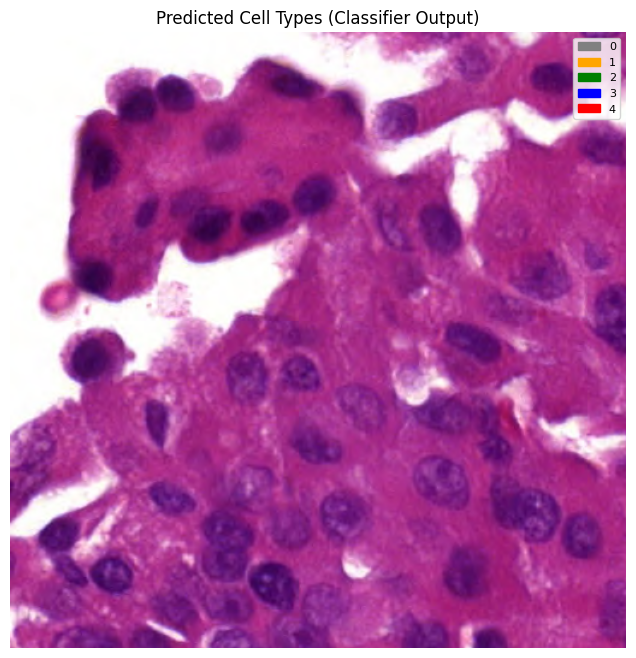

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# === Label map and colors ===
label_map = {
    0: "background",
    1: "epithelial",
    2: "lymphocyte",
    3: "macrophage",
    4: "neutrophil"
}

colors = {
    0: "gray",
    1: "orange",
    2: "green",
    3: "blue",
    4: "red"
}

# === Reload the original image for plotting ===
img_np = np.array(img)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_np)
ax.axis("off")

# === Overlay bounding boxes and predicted labels ===
# Each entry in cell_pred_dict[0] corresponds to one detected nucleus
for (cell_dict, pred_class) in zip(cell_pred_dict[0].values(), cell_preds):
    bbox = cell_dict["bbox"]  # [[ymin, xmin], [ymax, xmax]]
    color = colors.get(pred_class, "gray")

    rect = patches.Rectangle(
        (bbox[0][1], bbox[0][0]),
        bbox[1][1] - bbox[0][1],
        bbox[1][0] - bbox[0][0],
        linewidth=1.5,
        edgecolor=color,
        facecolor="none",
    )
    ax.add_patch(rect)

# === Create legend ===
handles = [
    patches.Patch(color=color, label=label)
    for label, color in colors.items() if label in label_map
]
ax.legend(handles=handles, loc="upper right", fontsize=8)
plt.title("Predicted Cell Types (Classifier Output)")
plt.show()


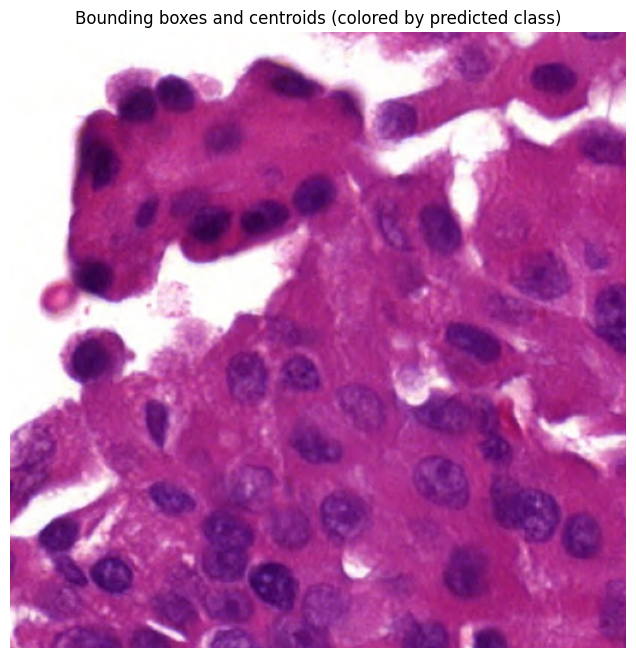

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_np)
ax.axis("off")

for (cell_dict, pred_class) in zip(cell_pred_dict[0].values(), cell_preds):
    bbox = cell_dict["bbox"]  # [[ymin, xmin], [ymax, xmax]]
    centroid = cell_dict["centroid"]
    color = colors.get(pred_class, "gray")

    # Draw bounding box
    rect = patches.Rectangle(
        (bbox[0][1], bbox[0][0]),
        bbox[1][1] - bbox[0][1],
        bbox[1][0] - bbox[0][0],
        linewidth=1.2,
        edgecolor=color,
        facecolor="none",
    )
    ax.add_patch(rect)

    # Draw centroid point
    ax.scatter(centroid[1], centroid[0], s=10, color=color)

plt.title("Bounding boxes and centroids (colored by predicted class)")
plt.show()


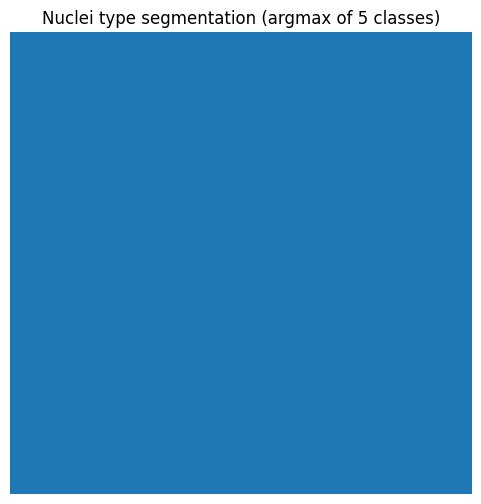

In [15]:
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    preds = cellvit_backbone(img_tensor, retrieve_tokens=False)

type_map = torch.argmax(preds["nuclei_type_map"], dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(6,6))
plt.imshow(type_map, cmap="tab10")
plt.title("Nuclei type segmentation (argmax of 5 classes)")
plt.axis("off")
plt.show()


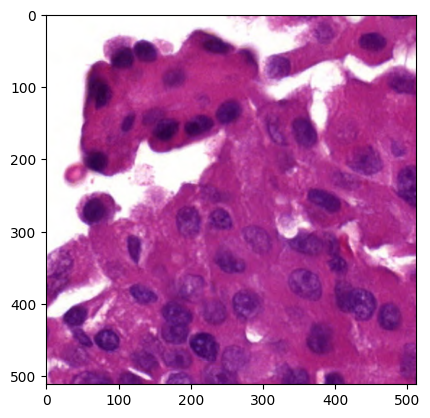

In [16]:
from skimage.measure import label, regionprops

type_map = torch.argmax(preds["nuclei_type_map"], dim=1).squeeze().cpu().numpy()
binary_mask = (type_map > 0).astype(int)
labeled = label(binary_mask)

centroids = [r.centroid for r in regionprops(labeled)]
plt.imshow(img_np)
for (y,x) in centroids:
    plt.scatter(x,y,s=10,color="orange")
plt.show()


In [20]:
import h5py, numpy as np, torch

cache_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/cache/5cf38f66df15bc85cbeda03fba4068ac0cd7427d741766a1e4176fb833e65adb.h5"  # inside your dataset's cache folder
#cache_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/cache/dbae478ffafcebbed642a52bf119923881a9f381351bd5b256ffbe6589c2bf72.h5"  # inside your dataset's cache folder

with h5py.File(cache_path, "r") as f:
    cached_token = torch.tensor(np.array(f["tokens"][0]))
print("Cached token variance:", cached_token.var().item())
print("Cached token mean:", cached_token.mean().item())


Cached token variance: 0.03486977673243053
Cached token mean: -0.013974880772972634


In [18]:
with torch.no_grad():
    preds = cellvit_backbone(torch.rand(1,3,512,512).to(device))
for k,v in preds.items():
    print(k, v.abs().mean().item(), v.abs().std().item())


/scratch/1219512.1.academic-gpu/ipykernel_1805214/2846397663.py:4: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(k, v.abs().mean().item(), v.abs().std().item())


tissue_types 0.030770406126976013 nan
nuclei_binary_map 0.07018841803073883 0.011643883772194386
hv_map 0.030467532575130463 0.028394492343068123
nuclei_type_map 0.06173911690711975 0.035074714571237564


In [32]:
import numpy as np
import torch, h5py

#cache_path = "/path/to/your/cache/<HASH>.h5"

with h5py.File(cache_path, "r") as f:
    # Load the first 100 for testing
    tokens_list = [np.array(x, dtype=np.float32) for x in f["tokens"][:100]]
    labels = np.array(f["types"][:100], dtype=np.int64)

# Stack into a 2D tensor (100 × 384)
tokens = torch.tensor(np.stack(tokens_list))
labels = torch.tensor(labels)
classifier.eval()
with torch.no_grad():
    preds = torch.argmax(classifier(tokens.to(device)), dim=1)
print("Accuracy on cached tokens:", (preds.cpu() == labels).float().mean().item())



Accuracy on cached tokens: 1.0


In [33]:
import torch, numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# one batch of cached tokens
cached_sample = tokens[:50].cpu().numpy()

# one batch of live tokens you extract from inference
live_sample = np.stack([t.cpu().numpy() for t in live_tokens[:50]])  # adjust to your variable

print("Cached mean/std:", cached_sample.mean(), cached_sample.std())
print("Live mean/std:",   live_sample.mean(), live_sample.std())

sim = np.mean(cosine_similarity(cached_sample, live_sample))
print("Average cosine similarity:", sim)


NameError: name 'live_tokens' is not defined

In [40]:
help(ExperimentBaseParser)

Help on class ExperimentBaseParser in module cellvit.training.base_ml.base_cli:

class ExperimentBaseParser(builtins.object)
 |  ExperimentBaseParser() -> None
 |  
 |  Configuration Parser for Machine Learning Experiments
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  parse_arguments(self) -> Tuple[Union[pydantic.main.BaseModel, dict]]
 |      Parse the arguments from CLI and load yaml config
 |      
 |      Returns:
 |          Tuple[Union[BaseModel, dict]]: Parsed arguments
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [41]:
from cellvit.training.experiments.experiment_cell_classifier import ExperimentCellVitClassifier
from cellvit.training.base_ml.base_cli import ExperimentBaseParser

config_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/train_configs/cellvit_train.yaml"

# load configuration
parser = ExperimentBaseParser()
configuration = parser.parse_arguments(config_path)

# build experiment
experiment = ExperimentCellVitClassifier(default_conf=configuration)

# run built-in inference (this does correct preprocessing + cell extraction)
experiment.evaluate_on_testset()


TypeError: ExperimentBaseParser.parse_arguments() takes 1 positional argument but 2 were given

In [42]:
import os
from cellvit.detect_cells import main as detect_main

# Arguments equivalent to CLI
args = [
    "--model", "./checkpoints/HIPT-256/CellViT-256-x40-AMP.pth",
    "--classifier_path", "./logs_local/2025-11-02T213346_cellvit++/checkpoints/model_best.pth",
    "--outdir", "./inference_results",
    "--gpu", "0",
    "--resolution", "0.25",
    "process_dataset",
    "--wsi_folder", "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/train/images",
    "--filelist", "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/splits/train.csv",
]

# Run in-memory inference
detect_main(args)


TypeError: main() takes 0 positional arguments but 1 was given

: 

In [4]:
from cellvit.training.datasets.detection_dataset import DetectionDataset
ds = DetectionDataset(
    dataset_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512",
    split="test",
    normalize_stains=True,
)
print(len(ds))
print(ds[0][0].shape, ds[0][3])  # (image tensor shape, image name)


0


IndexError: list index out of range

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/HIPT-256/CellViT-256-x40-AMP.pth'